# <font color='#42AAFF'>Содержание</font><a id='toc0_'></a>  <a id='toc0_'></a>    
1. [<font color='#42AAFF'>Введение</font>](#toc1_)    
2. [<font color='#42AAFF'>Обзор и предобработка данных</font>](#toc2_)    
2.1. [<font color='#42AAFF'>Выводы</font>](#toc2_1_)    
3. [<font color='#42AAFF'>Анализ</font>](#toc3_)    
3.1. [<font color='#42AAFF'>Выводы</font>](#toc3_1_)    
4. [<font color='#42AAFF'>Подготовка данных, обучение и оптимизация моделей</font>](#toc4_)    
4.1. [<font color='#42AAFF'>Функции</font>](#toc4_1_)    
4.2. [<font color='#42AAFF'>Экспоненциальные модели</font>](#toc4_2_)    
4.2.1. [<font color='#42AAFF'>Тренировочная и тестовая выборки</font>](#toc4_2_1_)    
4.2.2. [<font color='#42AAFF'>Простое экспоненциальное сглаживание (Simple Exponential Smoothing)</font>](#toc4_2_2_)    
4.2.3. [<font color='#42AAFF'>Двойное экспоненциальное сглаживание (Double Exponential Smoothing or Holt model)</font>](#toc4_2_3_)    
4.2.4. [<font color='#42AAFF'>Тройное экспоненциальное сглаживание (Tripple Exponential Smoothing or Holt-Winter's model)</font>](#toc4_2_4_)    
4.3. [<font color='#42AAFF'>Модели SARIMAX</font>](#toc4_3_)    
4.3.1. [<font color='#42AAFF'>Тренировочная и тестовая выборки</font>](#toc4_3_1_)    
4.3.2. [<font color='#42AAFF'>Выбор параметров модели на основе анализа ACF, PACF</font>](#toc4_3_2_)    
4.3.3. [<font color='#42AAFF'>Оптимизация параметров модели</font>](#toc4_3_3_)    
4.3.4. [<font color='#42AAFF'>Выводы</font>](#toc4_3_4_)    
4.4. [<font color='#42AAFF'>Линейная регрессия</font>](#toc4_4_)    
4.4.1. [<font color='#42AAFF'>Функции</font>](#toc4_4_1_)    
4.5. [<font color='#42AAFF'>CatBoost</font>](#toc4_5_)    
4.6. [<font color='#42AAFF'>XGBoost</font>](#toc4_6_)    
4.7. [<font color='#42AAFF'>LightGBM</font>](#toc4_7_)    
4.8. [<font color='#42AAFF'>Выводы</font>](#toc4_8_)    
5. [<font color='#42AAFF'>Тестирование</font>](#toc5_)    
5.1. [<font color='#42AAFF'>Экспоненциальные модели</font>](#toc5_1_)    
5.2. [<font color='#42AAFF'>SARIMAX</font>](#toc5_2_)    
5.3. [<font color='#42AAFF'>Линейная регрессия</font>](#toc5_3_)    
5.4. [<font color='#42AAFF'>CatBoost</font>](#toc5_4_)    
5.5. [<font color='#42AAFF'>XGBoost</font>](#toc5_5_)    
5.6. [<font color='#42AAFF'>LightGBM</font>](#toc5_6_)    
6. [<font color='#42AAFF'>Общие выводы</font>](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[<font color='#42AAFF'>Введение</font>](#toc0_)

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

<b>Описание данных</b>

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# 2. <a id='toc2_'></a>[<font color='#42AAFF'>Обзор и предобработка данных</font>](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.fft as fft
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy.optimize import minimize, Bounds
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score,mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,KFold,ParameterGrid
from sklearn.feature_selection import RFE
from statsmodels.tsa.stattools import adfuller
import warnings

c:\Users\takra\Anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv('datasets/taxi.csv')

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1 MB


In [4]:
data.head()

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

Преобразуем тип данных для `datetime`:

In [5]:
data['datetime'] = data['datetime'].astype('datetime64')

In [6]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Убедимся, что пропуски отсутствуют:

In [7]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

Установим `datetime` в качестве индекса:

In [8]:
data = data.set_index('datetime')

Убедимся, что временной ряд монотонен:

In [9]:
data.index.is_monotonic

True

## 2.1. <a id='toc2_1_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Загрузили данные - 26495 строк и 2 столбца: `datetime` - время, `num_orders` - число заказов.
2. Преобразовали тип данных `datetime` в `datetime64` и выбрали столбец в качестве индекса.
3. Проверили, что пропусков в данных нет.
4. Убедились, что столбец времени монотонен.

# 3. <a id='toc3_'></a>[<font color='#42AAFF'>Анализ</font>](#toc0_)

В соответствии с заданием изменим частоту дискретизации данных до 1 часа:

In [10]:
data_1H = data.resample('1H').sum()

In [11]:
data['rolling'] = data['num_orders'].rolling(24*7).mean()

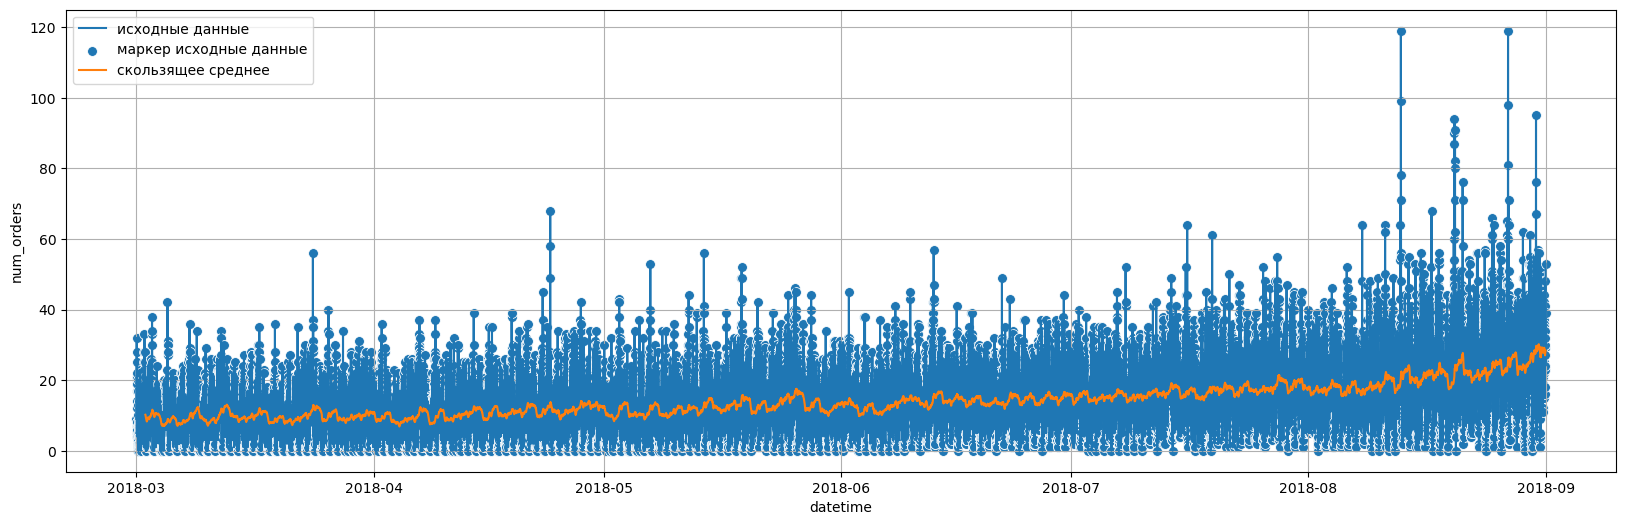

In [12]:
fig, axs = plt.subplots(figsize=(20,6))
sns.lineplot(x=data.index,y=data['num_orders'],ax=axs)
sns.scatterplot(x=data.index,y=data['num_orders'],marker='o',s=50,ax=axs)
sns.lineplot(x=data.index,y=data['rolling'],ax=axs)
#axs.set(xlim=(350,450)) 
axs.grid(True)
axs.legend(['исходные данные','маркер исходные данные','скользящее среднее'])  
#axs.set(xlabel='datetime',title='data')  
plt.show()

По скользящему среднему видим наличие тренда и некоторую периодичность. Воспользуемся seasonal_decompose для выявление компонент временного ряда:

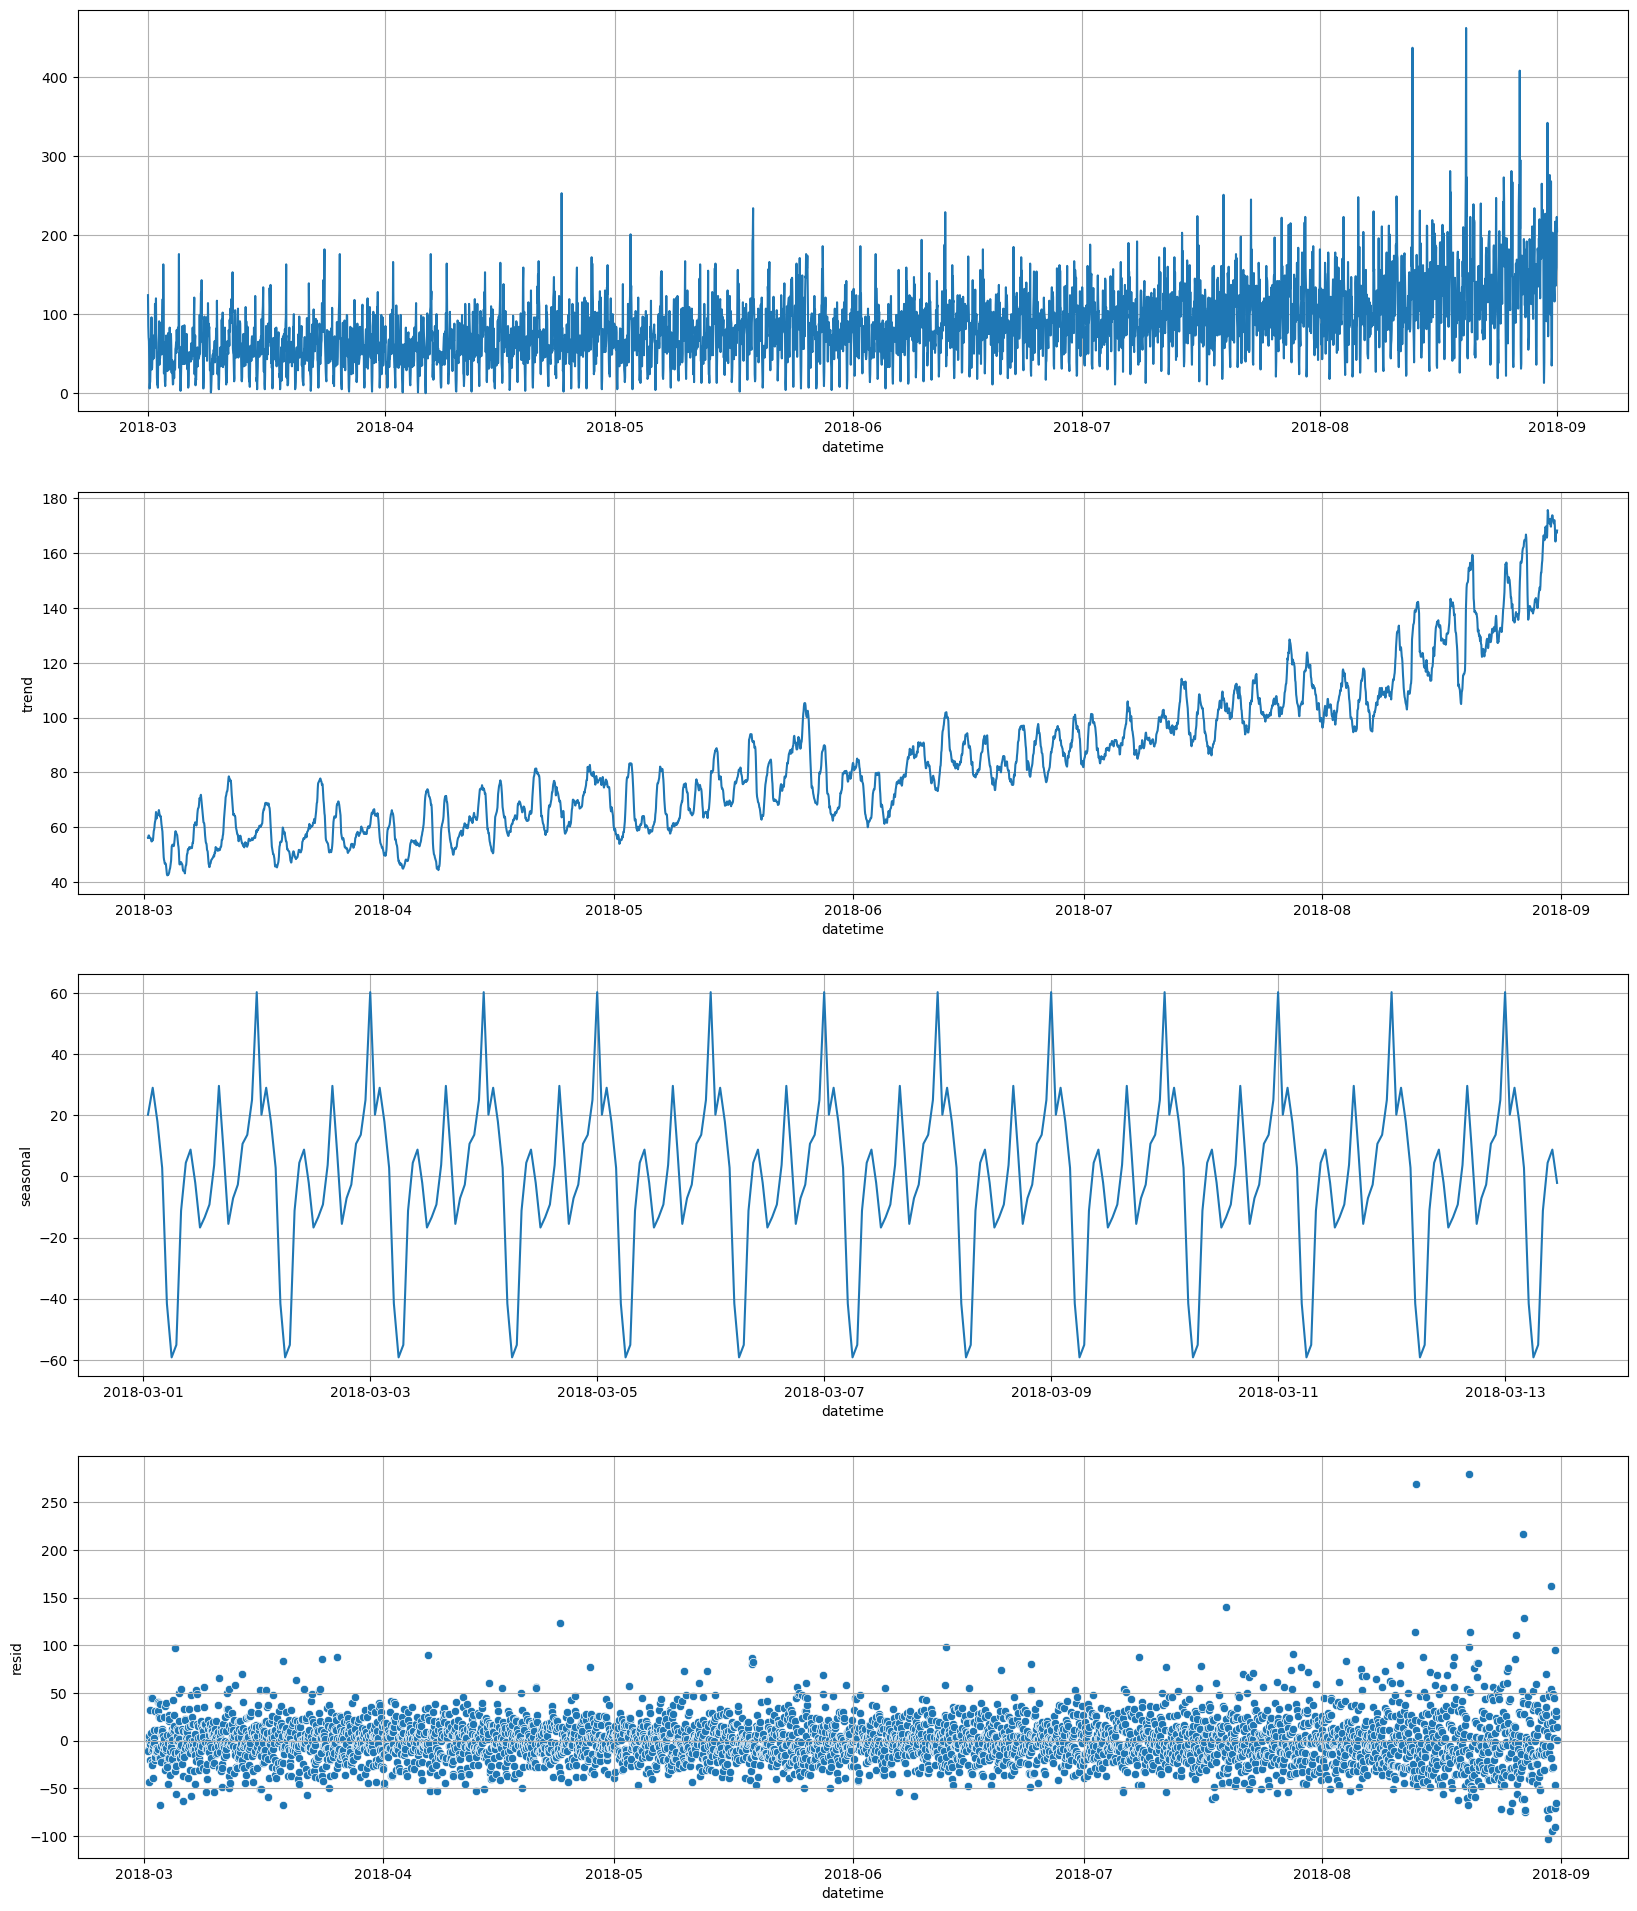

In [13]:
decomposed = seasonal_decompose(data_1H, model='additive')
fig, axs = plt.subplots(nrows=4, figsize=(20,24))
sns.lineplot(x=data_1H.index,y=decomposed.observed,ax=axs[0])
sns.lineplot(x=data_1H.index,y=decomposed.trend,ax=axs[1])
sns.lineplot(x=data_1H.index[1:300],y=decomposed.seasonal[1:300],ax=axs[2])
sns.scatterplot(x=data_1H.index,y=decomposed.resid,ax=axs[3])
for ax in axs:
    ax.grid(True) 
plt.show()

In [14]:
print(f'Средний модуль остатков {np.mean(np.abs(decomposed.resid)):2.1f}')

Средний модуль остатков 18.1


1. По графику хорошо видна суточная периодичность с амплитудой в 60 вызовов.
2. Также можно предполагать некоторую периодичность, которую видно на тренде.
3. Средний модуль остатка относительно небольшой - 18.1 (меньше влияния тренда и сезонности), но присутствуют амплитудные выбросы.

Проверим стационарность ряда остатков с помощью тест Дики-Фуллера:

In [15]:
adf_test = adfuller(data_1H)
print(
    f'Результаты теста Дики-Фуллера:'
    f'Тестовая статистика: {adf_test[0]:3.1f}\n'
    f'p-значение: {adf_test[1]:0.2f}\n'
    f'Число лагов: {adf_test[2]:0.2f}\n'
    f'Критериальная статистика при уровне значимости 0.01: {adf_test[4]["1%"]:0.2f}\n'
    f'Критериальная статистика при уровне значимости 0.05: {adf_test[4]["5%"]:0.2f}\n'
    f'Критериальная статистика при уровне значимости 0.1: {adf_test[4]["10%"]:0.2f}\n'    
    )

Результаты теста Дики-Фуллера:Тестовая статистика: -3.1
p-значение: 0.03
Число лагов: 30.00
Критериальная статистика при уровне значимости 0.01: -3.43
Критериальная статистика при уровне значимости 0.05: -2.86
Критериальная статистика при уровне значимости 0.1: -2.57



При 5% уровне значимости нулевая гипотеза отвергнута - ряд остатков стационарен даже без вычета разностного компонента.

In [16]:
#частота исходного сигнала
SAMPLE_RATE = 60*60/(data_1H.index[1] - data_1H.index[0]).total_seconds()
#количество отсчётов в сигнале
N = int((data_1H.index[-1] - data_1H.index[0]).total_seconds()/3600 * SAMPLE_RATE)+1
print(
    f'частота: {SAMPLE_RATE:3.4f} 1/час \n'
    f'количество отсчетов: {N:5.0f}'
    )

частота: 1.0000 1/час 
количество отсчетов:  4416


In [17]:
yf = fft.rfft(data_1H['num_orders'])
xf = fft.rfftfreq(N, 1/SAMPLE_RATE)

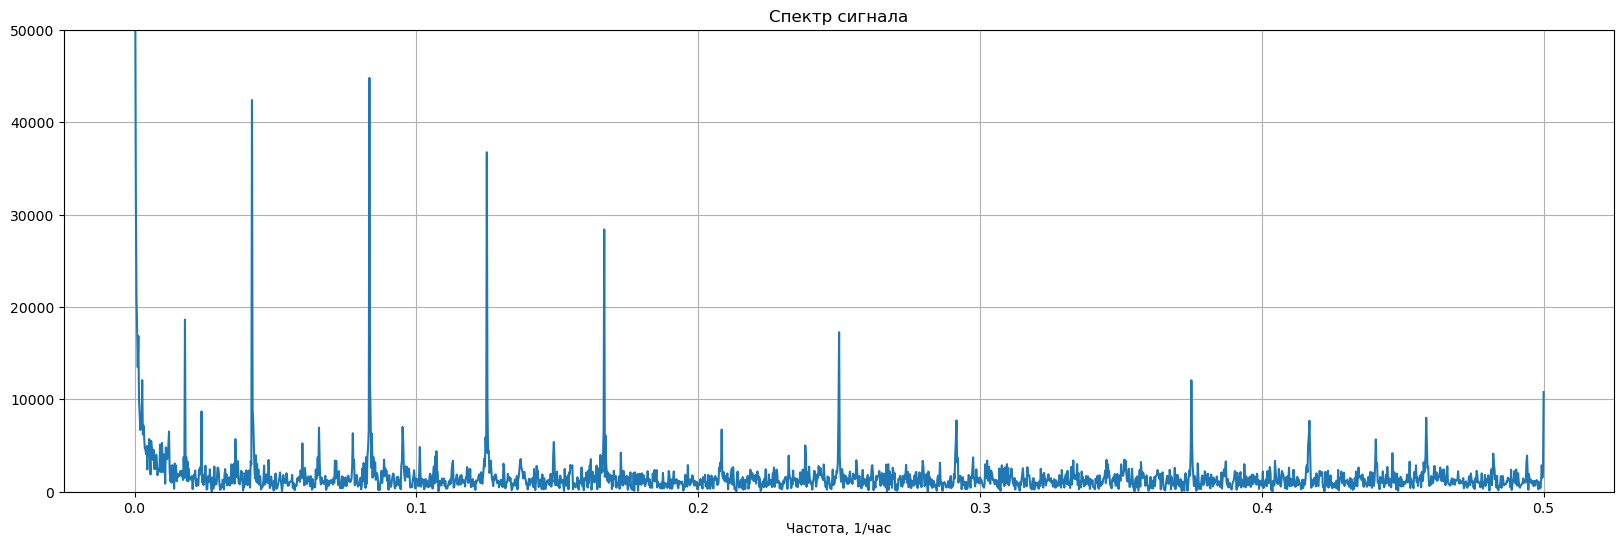

In [18]:
fig, axs = plt.subplots(figsize=(20,6))
sns.lineplot(x=xf,y=np.abs(yf),ax=axs)
axs.grid(True)
#axs.legend(['', ''])  
axs.set(
    xlabel='Частота, 1/час',
    title='Спектр сигнала',
    ylim=[0,50e3]
    #xlim=[0,2e-4]
    )  
plt.show()

In [19]:
df_fft = pd.DataFrame({'xf_1h':xf, 'yf':np.abs(yf)}).sort_values(by='yf', ascending=False).reset_index(drop=True).head(15)
df_fft['T_1h'] = 1/df_fft['xf_1h']
df_fft.drop('yf',axis=1).query("T_1h < 500").applymap('{:.3f}'.format)

xf_1h     T_1h
2   0.083   12.000
3   0.042   24.000
4   0.125    8.000
6   0.167    6.000
8   0.018   55.899
10  0.250    4.000
13  0.003  368.000
14  0.375    2.667

Согласно спектру сигнала выделить первые 6 основных периодических компонент:
1. 6 часовая
2. 8 часовая
3. 12 часовая
4. 24 часовая
5. 55.9 часовая
6. 4 часовая

## 3.1. <a id='toc3_1_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Изменили частоту дискретизации данных до 1 часа.
2. Показали, что исходный ряд имеет тренд и сезонные компоненты.
3. Проверили стационарность ряда остатков с помощью расширенного теста Дики-Фуллера.

# 4. <a id='toc4_'></a>[<font color='#42AAFF'>Подготовка данных, обучение и оптимизация моделей</font>](#toc0_)

## 4.1. <a id='toc4_1_'></a>[<font color='#42AAFF'>Функции</font>](#toc0_)

Подготовим класс для блочного разбиения тренировочного временного ряда для кроссвалидации:

In [20]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, size_ratio=0.5):
        self.n_splits = n_splits
        self.size_ratio = size_ratio
    
    def get_n_splits(self,X,y,groups):
        return self.n_splits

    def get_size_ratio(self,X,y,groups):
        return self.size_ratio
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(self.size_ratio * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

Подготовим функцию для визуализации разбиения:

In [21]:
def split_plot(cv,X):
    n_splits = cv.get_n_splits(X,0,0)
    fig, axs = plt.subplots(figsize=(10,6)) 
    cmap = plt.cm.coolwarm
    for ii, (tr, tt) in enumerate(cv.split(X,0,0)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        axs.scatter(
        range(len(indices)),
        [ii + 1] * len(indices),
        c=indices,
        marker="_",
        lw=30,
        cmap=cmap,
        vmin=-0.2,
        vmax=1.2,
        )
    axs.grid(True)    
    yticklabels = list(range(n_splits))
    axs.set(
        yticks=np.arange(1,n_splits+1,1),
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits+1, -0.2]                
        )
    axs.legend([mpatches.Patch(color=cmap(0.8)), mpatches.Patch(color=cmap(0.2))],["Testing set", "Training set"])   
    axs.set_title('TimeSeriesSplit')
    plt.show()
    return

Подготовим функцию для расчёта метрики RMSE:

In [22]:
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

Функция визуализации прогноза:

In [23]:
def plot_forecast(train,test,predict_train, predict_test, title, zoom=False, xlim=[-100 -1]):    
    #print(train.shape)
    fig, axs = plt.subplots(figsize=(20,6))
    sns.lineplot(x=train.index,y=train[train.columns[0]],ax=axs)
    sns.lineplot(x=test.index,y=test[test.columns[0]],ax=axs)
    sns.lineplot(x=predict_train.index,y=predict_train[predict_train.columns[0]],ax=axs)
    sns.lineplot(x=predict_test.index,y=predict_test[predict_test.columns[0]],ax=axs)
    axs.grid(True)
    axs.legend(['тренировочная выборка','тестовая выборка','прогноз на тренировочной выборке','прогноз на тестовой выборке'])  
    axs.set(title=title)  
    plt.show()
    if zoom ==True:
        fig, axs = plt.subplots(figsize=(20,6))
        sns.lineplot(x=train.index,y=train[train.columns[0]],ax=axs)
        sns.lineplot(x=test.index,y=test[test.columns[0]],ax=axs)
        sns.lineplot(x=predict_train.index,y=predict_train[predict_train.columns[0]],ax=axs)
        sns.lineplot(x=predict_test.index,y=predict_test[predict_test.columns[0]],ax=axs)        
        axs.grid(True)
        axs.legend(['тренировочная выборка','тестовая выборка','прогноз на тренировочной выборке','прогноз на тестовой выборке'])  
        axs.set(title=title+' zoom', xlim=(train.index[xlim[0]],test.index[xlim[1]]))  
        plt.show()
    return

## 4.2. <a id='toc4_2_'></a>[<font color='#42AAFF'>Экспоненциальные модели</font>](#toc0_)

### 4.2.1. <a id='toc4_2_1_'></a>[<font color='#42AAFF'>Тренировочная и тестовая выборки</font>](#toc0_)

Разобьем выборку на тренировочную (90%) и тестовую (10%):

In [24]:
train = data_1H[:3974]
test = data_1H[3975:]

Подготовим функции для оптимизации параметров экспоненциальных моделей на кроссвалидации:

In [25]:
def opt_cv_ExpSm(data,folds,param_grid):
    
    pg = list(ParameterGrid(param_grid))
    #data = data.values
    test_errors = []
    best_score = 1e6
    best_parameters = []

    for a,b in enumerate(pg):        
        sl = b.get('smoothing_level')
        st = b.get('smoothing_trend')
        ss = b.get('smoothing_seasonal')
        dt = b.get('damping_trend')
        dtb = b.get('damped_trend')
        tq = b.get('trend')
        s = b.get('seasonal')
        sp = b.get('seasonal_periods')
        # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
        tt_errors = []
        tr_errors = []      
        for tr, tt in folds.split(data):
            predict_train=[]
            predict_test=[]
            model = ExponentialSmoothing(
                endog=data.iloc[tr].values,
                trend=tq,
                damped_trend=dtb,
                seasonal=s,
                seasonal_periods =sp                
                )        
            model_fitted = model.fit(
                smoothing_level=sl,
                smoothing_trend=st,
                smoothing_seasonal=ss,                
                damping_trend=dt,
                optimized=False,
                use_brute=True
                )
            predict_train = model_fitted.fittedvalues            
            tr_errors.append(RMSE(data.iloc[tr].values, predict_train))
            predict_test = model_fitted.forecast(len(tt))             
            tt_errors.append(RMSE(data.iloc[tt].values, predict_test))        
        test_errors.append(np.mean(tt_errors))
        #print(f'{a}: mean test RMSE  {np.mean(tt_errors):.1f} ({np.std(tt_errors):.1f}), {tt_errors}')
        #print(data.iloc[tr].shape)
        if best_score > np.mean(tt_errors):
            best_score = np.mean(tt_errors)
            best_score_last = tt_errors[-1]
            best_parameters = b                
    print(
        f'best mean test RMSE: {best_score:.1f} \n'
        f'best model full test RMSE: {best_score_last:.1f} \n'
        f'best model: {best_parameters}'
    )       
    return best_score, best_parameters, data.iloc[tr], data.iloc[tt]

In [26]:
def predict_ExpSm(train, test, params):
    model_fitted = ExponentialSmoothing(
    endog = train,
    trend = params['trend'],
    damped_trend = params['damped_trend'],
    seasonal = params['seasonal'],
    seasonal_periods =  params['seasonal_periods']             
    ).fit(
        smoothing_level = params['smoothing_level'],
        smoothing_trend = params['smoothing_trend'],
        smoothing_seasonal = params['smoothing_seasonal'],
        damping_trend = params['damping_trend'],                     
        optimized=False,
        use_brute=True
        )
    predict_train = model_fitted.fittedvalues
    predict_test = model_fitted.forecast(len(test)) 
    print(
        f'RMSE на тренировочной выборке: {RMSE(train.values, predict_train):.1f}\n'
        f'RMSE на тестовой выборке: {RMSE(test.values, predict_test):.1f}'
    )
    return pd.DataFrame(predict_train), pd.DataFrame(predict_test)

In [27]:
cv = BlockingTimeSeriesSplit(n_splits=3, size_ratio=0.9)

Визуализируем кроссвалидационные выборки:

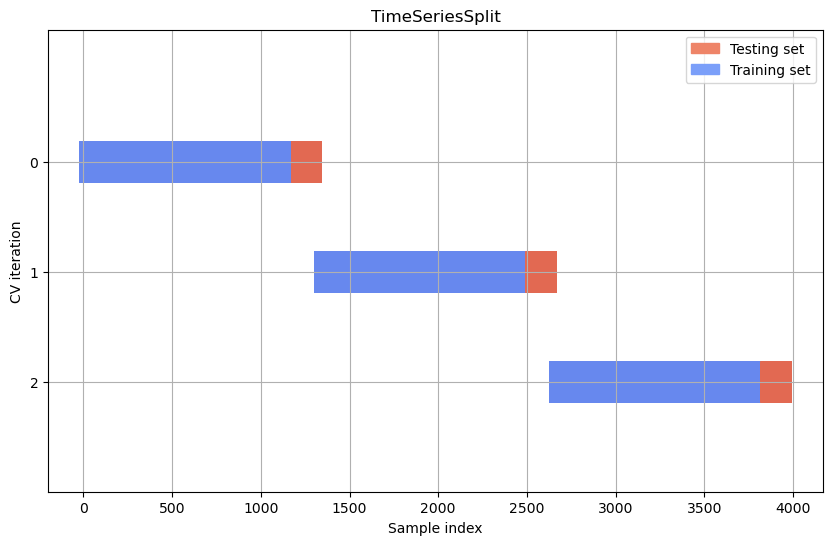

In [28]:
split_plot(cv,train)

### 4.2.2. <a id='toc4_2_2_'></a>[<font color='#42AAFF'>Простое экспоненциальное сглаживание (Simple Exponential Smoothing)</font>](#toc0_)

SES модель способная предсказывать средний уровень, но не способна предсказывать тренд или сезонность. Прогноз на шаге t+1 вычисляется как средневзвешенное фактического значения на шаге t и прогноза уровня на шаге t, при этом вес называется сглаживающим фактором.

${\ell}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot {\ell}_{t-1}$

$\ell_0 = y_0$

$\widehat{y}_{t+1} = {\ell}_t$

In [29]:
param_grid = {
            'smoothing_level': [0.001, 0.005, 0.01, 0.02, 0.03, 0.3, 0.5, 1.0], 
            'smoothing_trend':[0],
            'smoothing_seasonal':[0],
            'damping_trend': [0],
            'damped_trend': [False],
            'trend':[None],
            'seasonal':[None],
            'seasonal_periods':[0]
            }

In [30]:
%%time
score, params_ses, train_cv_last, test_cv_last = opt_cv_ExpSm(train,cv,param_grid)

best mean test RMSE: 41.3 
best model full test RMSE: 56.7 
best model: {'damped_trend': False, 'damping_trend': 0, 'seasonal': None, 'seasonal_periods': 0, 'smoothing_level': 0.01, 'smoothing_seasonal': 0, 'smoothing_trend': 0, 'trend': None}
Wall time: 148 ms


Вычислим предсказание лучшей модели на тренировочной и тестовой части последней кроссвалидационной выборки:

In [31]:
predict_train, predict_test = predict_ExpSm(train_cv_last, test_cv_last, params_ses)

RMSE на тренировочной выборке: 36.6
RMSE на тестовой выборке: 56.7


Визализируем прогноз на последней кроссвалидационной выборке:

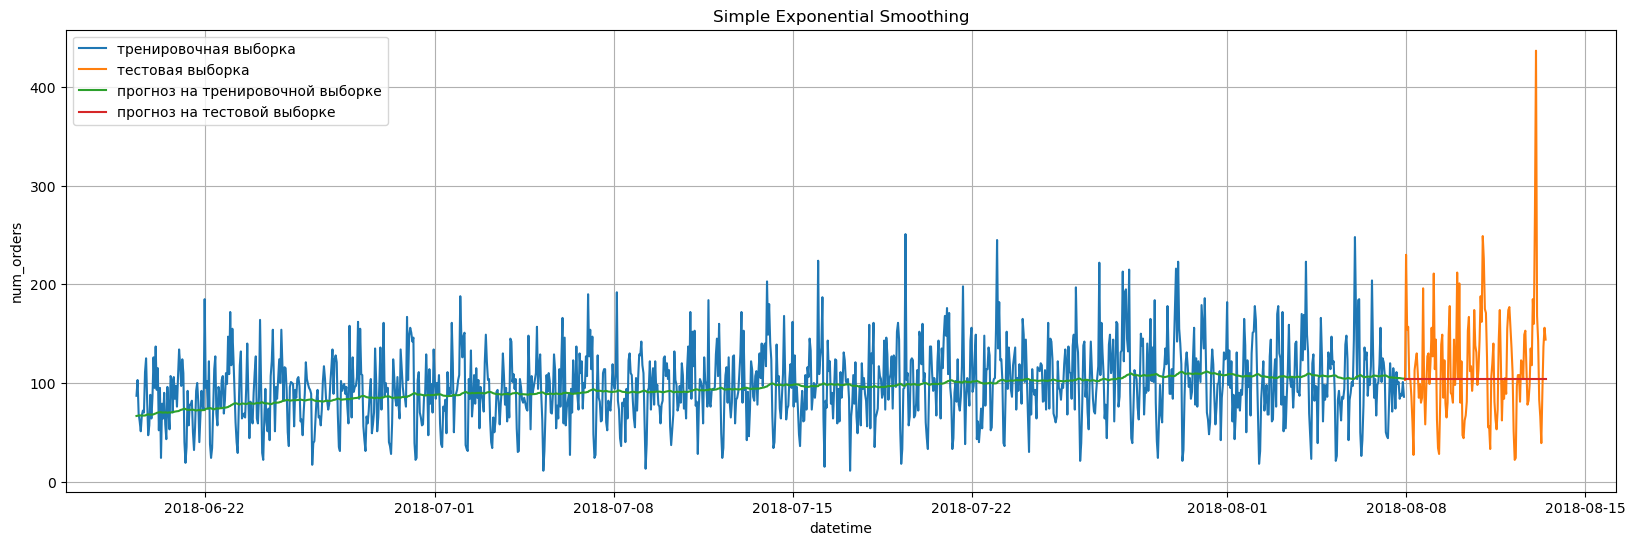

In [32]:
plot_forecast(train_cv_last, test_cv_last, predict_train, predict_test, 'Simple Exponential Smoothing')

Как видно по графику простейшая модель дает лишь прогноз среднего без учета тренда и сезонности, что соответствует логике модели. Метрика выше ожидаемых 48.

### 4.2.3. <a id='toc4_2_3_'></a>[<font color='#42AAFF'>Двойное экспоненциальное сглаживание (Double Exponential Smoothing or Holt model)</font>](#toc0_)

Двойное экспоненциальное сглаживание является более сложным инструментом прогнозирования и предсказывает не только уровень, но и тренд.

$\ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$

$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

$\widehat{y}_{t+m} = \ell_t + m \cdot b_t$

In [33]:
param_grid = {
            'smoothing_level': [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0], 
            'smoothing_trend':[0.003, 0.005, 0.01, 0.02, 0.1, 0.4, 0.8, 1.0],
            'smoothing_seasonal':[0],
            'damping_trend': [0.001, 0.003, 0.005, 0.01, 0.015, 0.1, 0.4, 0.6, 0.8, 1.0],
            'damped_trend': [True,False],
            'trend':['add'],
            'seasonal':[None],
            'seasonal_periods':[0]
            }

In [34]:
%%time
score, params_des, train_cv_last, test_cv_last = opt_cv_ExpSm(train,cv,param_grid)

best mean test RMSE: 41.2 
best model full test RMSE: 56.6 
best model: {'damped_trend': True, 'damping_trend': 1.0, 'seasonal': None, 'seasonal_periods': 0, 'smoothing_level': 0.01, 'smoothing_seasonal': 0, 'smoothing_trend': 0.005, 'trend': 'add'}
Wall time: 1min 41s


Вычислим предсказание лучшей модели на тренировочной и тестовой части последней кроссвалидационной выборки:

In [35]:
predict_train, predict_test = predict_ExpSm(train_cv_last, test_cv_last, params_des)

RMSE на тренировочной выборке: 86.6
RMSE на тестовой выборке: 56.6


Визализируем прогноз на последней кроссвалидационной выборке:

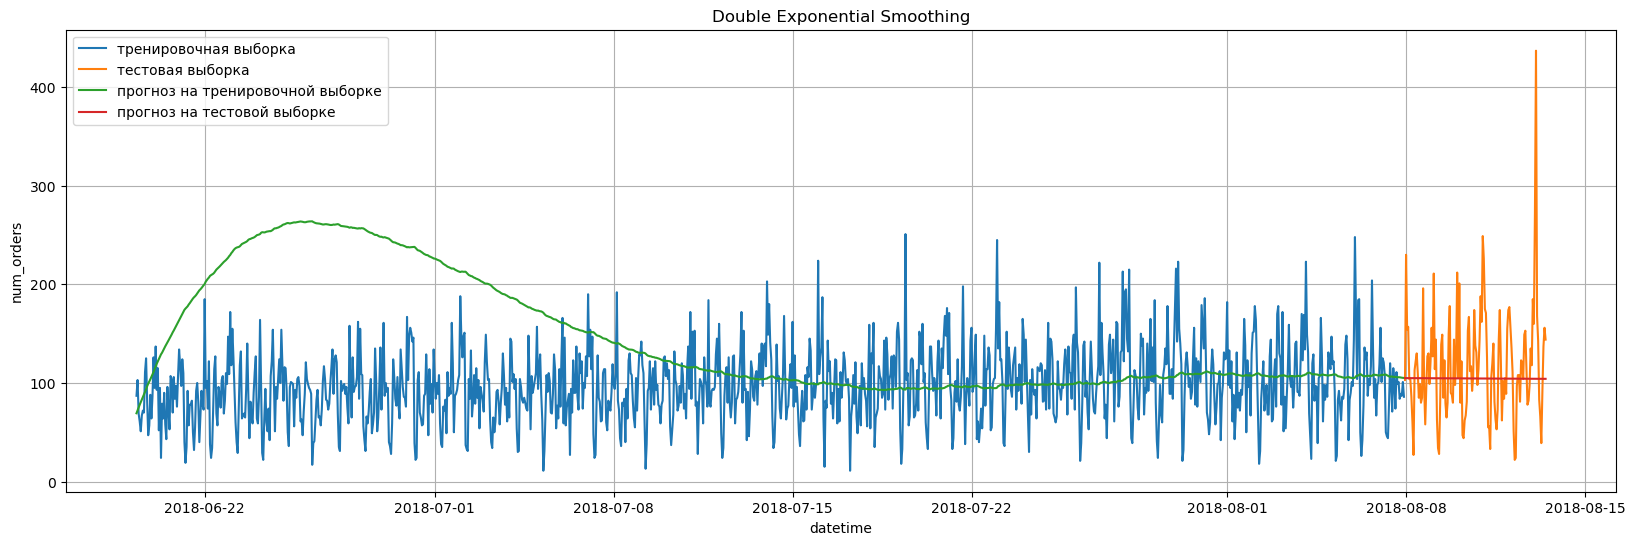

In [36]:
plot_forecast(train_cv_last, test_cv_last, predict_train, predict_test, 'Double Exponential Smoothing')

Как видно по графику - появился тренд, но прогноз оставляет желать лучшего.

### 4.2.4. <a id='toc4_2_4_'></a>[<font color='#42AAFF'>Тройное экспоненциальное сглаживание (Tripple Exponential Smoothing or Holt-Winter's model)</font>](#toc0_)

Модель Хольта-Винтера позволяет учитывать не только уровень и тренд, но еще и сезонность (периодическую компоненту)

$\ell_t = \alpha(y_t - s_{t-L}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$


$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

$s_t = \gamma(y_t - \ell_t) + (1-\gamma)s_{t-L}$

$\widehat{y}_{t+m} = \ell_t + m \cdot b_t + s_{t-L+1+(m-1)modL}$

In [37]:
param_grid = {
            'smoothing_level': [0.001, 0.002, 0.003, 0.005, 0.02, 0.2, 0.4], 
            'smoothing_trend':[0.002, 0.005, 0.01, 0.02, 0.1, 0.2],
            'smoothing_seasonal':[0.005, 0.01, 0.1, 0.4, 0.5, 0.6, 0.8],
            'damping_trend': [0.001, 0.002, 0.005, 0.02, 0.1, 0.6, 0.8],
            'damped_trend': [True,False],
            'trend':['add'],
            'seasonal':['add'],            
            'seasonal_periods':[24,84,168]
            }

In [38]:
%%time
score, params_tes, train_cv_last, test_cv_last = opt_cv_ExpSm(train,cv,param_grid)

best mean test RMSE: 26.4 
best model full test RMSE: 36.4 
best model: {'damped_trend': False, 'damping_trend': 0.001, 'seasonal': 'add', 'seasonal_periods': 168, 'smoothing_level': 0.002, 'smoothing_seasonal': 0.4, 'smoothing_trend': 0.005, 'trend': 'add'}
Wall time: 17min 57s


Вычислим предсказание лучшей модели на тренировочной и тестовой части последней кроссвалидационной выборки:

In [39]:
predict_train, predict_test = predict_ExpSm(train_cv_last, test_cv_last, params_tes)

RMSE на тренировочной выборке: 21.2
RMSE на тестовой выборке: 36.4


Визализируем прогноз на последней кроссвалидационной выборке:

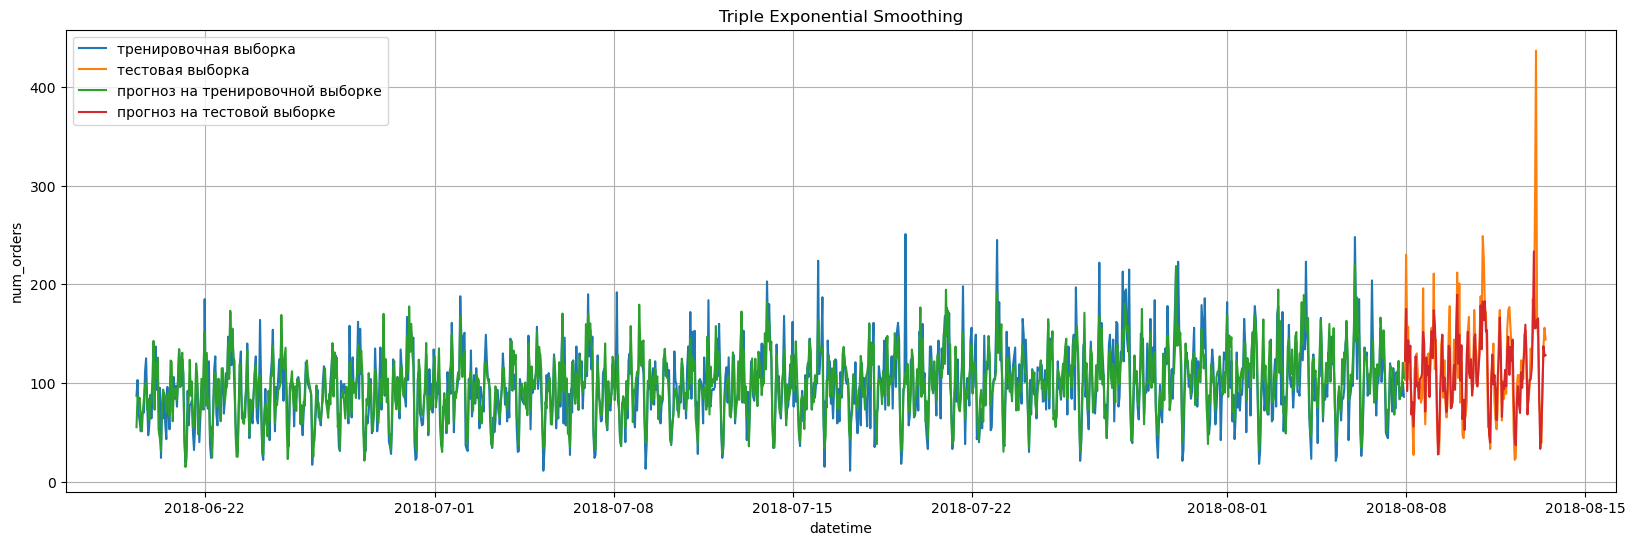

In [40]:
plot_forecast(train_cv_last, test_cv_last, predict_train, predict_test, 'Triple Exponential Smoothing')

С учетом сезонности прогноз все более близок к реальности, но точность прогноза все еще не очень высокая.

## 4.3. <a id='toc4_3_'></a>[<font color='#42AAFF'>Модели SARIMAX</font>](#toc0_)

### 4.3.1. <a id='toc4_3_1_'></a>[<font color='#42AAFF'>Тренировочная и тестовая выборки</font>](#toc0_)

In [41]:
def sarimax_prepare_data(data, lags, test_ratio=0.1):
    
    data = pd.DataFrame(data.copy())
       
   # добавляем лаги исходного ряда в качестве признаков
    for ll in lags:
        data['lag_{}'.format(ll)] = data[data.columns[0]].shift(ll)

    data = data.dropna()
    #data = data.reset_index(drop=True)               
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    margin_index = int(len(data)*(1-test_ratio))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    x_train = data.iloc[:margin_index].drop([data.columns[0]], axis=1)
    y_train = data.iloc[:margin_index][[data.columns[0]]]
    x_test = data.iloc[margin_index:].drop([data.columns[0]], axis=1)
    y_test = data.iloc[margin_index:][[data.columns[0]]]

    return x_train, y_train, x_test, y_test

In [42]:
cv = BlockingTimeSeriesSplit(n_splits=3, size_ratio=0.9)

In [43]:
x_train_sarimax, y_train, x_test_sarimax, y_test = sarimax_prepare_data(data_1H, [12, 24, 48, 120, 168])

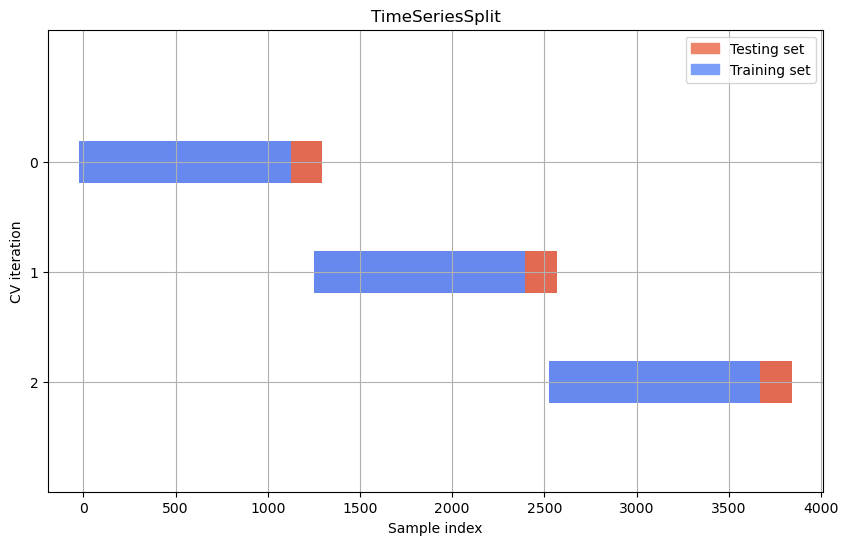

In [44]:
split_plot(cv,x_train_sarimax)

### 4.3.2. <a id='toc4_3_2_'></a>[<font color='#42AAFF'>Выбор параметров модели на основе анализа ACF, PACF</font>](#toc0_)

ARIMA модель в качестве входных параметров использует 3 параметра:
 - p - порядок авторегрессии,
 - d - порядок разности,
 - q - порядок скользящего среднего.
 
Ранее уже тестировали исходные данные с помощью критерия Дики-Фуллера: при значимости 0.05 ряд оказался стационарным даже без учета разности.
Выберем параметры модели используя анализ графиков автокорреляции, частичной автокорреляции и тест Дики-Фуллера для проверки стационарности ряда остатков.

Протестируем стационарность исходного ряда:

In [45]:
adf_test = adfuller(y_train)
print(
    f'Результаты теста Дики-Фуллера:'
    f'Тестовая статистика: {adf_test[0]:3.1f}\n'
    f'p-значение: {adf_test[1]:0.2f}\n'
    f'Число лагов: {adf_test[2]:0.2f}\n'
    f'Критериальная статистика при уровне значимости 0.01: {adf_test[4]["1%"]:0.2f}\n'
    f'Критериальная статистика при уровне значимости 0.05: {adf_test[4]["5%"]:0.2f}\n'
    f'Критериальная статистика при уровне значимости 0.1: {adf_test[4]["10%"]:0.2f}\n'    
    )

Результаты теста Дики-Фуллера:Тестовая статистика: -4.4
p-значение: 0.00
Число лагов: 30.00
Критериальная статистика при уровне значимости 0.01: -3.43
Критериальная статистика при уровне значимости 0.05: -2.86
Критериальная статистика при уровне значимости 0.1: -2.57



Таким образом, исходный ряд стационарен, следовательно можно принять d равным 0.

Построим графики автокорреляции и частичной автокорреляции:

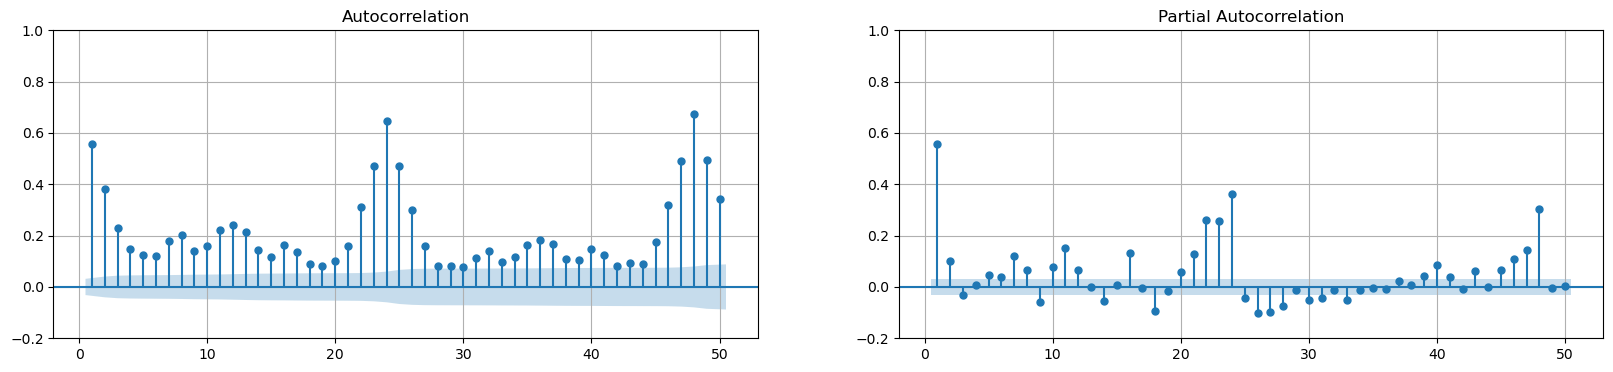

In [46]:
fig, axs = plt.subplots(ncols=2,figsize=(20,4))

# Plotting ACF and PACF 
tsaplots.plot_acf(y_train.num_orders, zero = False, lags = 50,  ax = axs[0])
tsaplots.plot_pacf(y_train.num_orders, zero = False, lags = 50, method='ywm', ax = axs[1])
for ax in axs:
    ax.grid(True)
    ax.set_ylim(-0.2,1)
plt.show()

1. По графику частичной автокорреляции видно, что наибольшее влияние имеет 1 лаг, тогда может выбрать порядок авторегрессии равным p = 1.
2. По графику автокорреляции видно, что все коэффициенты положительные, следовательно, присутствует тренд, кроме того есть периодичность каждые 24 отсчета. Выберем параметр q = 1.

Обучим модель с параметрами (1,0,1) и посмотрим на ACF, PACF остатков.

                               SARIMAX Results                                
Dep. Variable:             num_orders   No. Observations:                 3823
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -18898.699
Date:                Fri, 17 Mar 2023   AIC                          37803.397
Time:                        15:07:54   BIC                          37822.144
Sample:                    03-08-2018   HQIC                         37810.058
                         - 08-14-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9750      0.003    287.292      0.000       0.968       0.982
ma.L1         -0.4395      0.013    -34.790      0.000      -0.464      -0.415
sigma2      1151.0284     20.993     54.829      0.0

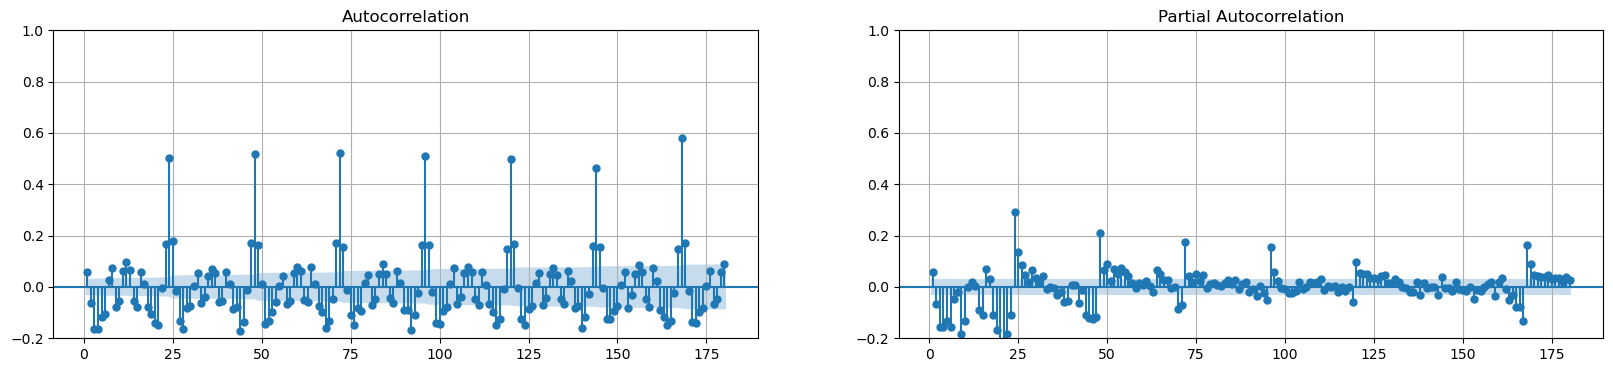

In [47]:
# Defining the Model
model = SARIMAX(
    endog = y_train, 
    order = (1, 0, 1)
    ).fit()
# Fitting the Model
print(model.summary())

fig, axs = plt.subplots(ncols=2,figsize=(20,4))

# Plotting ACF and PACF 
tsaplots.plot_acf(model.resid, zero = False, lags = 180,  ax = axs[0])
tsaplots.plot_pacf(model.resid, zero = False, lags = 180, method='ywm', ax = axs[1])
for ax in axs:
    ax.grid(True)
    ax.set_ylim(-0.2,1)
plt.show()

По графику автокорреляции видно, что трендовая составляющая стала значительно меньше, но осталась неучтенная сезонная с периодом 24. Учтем сезонную составляющую в SARIMA модели с параметрами(1,0,1)(1,0,1,24). 

c:\Users\takra\Anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3823
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 48)   Log Likelihood              -17417.296
Date:                            Fri, 17 Mar 2023   AIC                          34844.591
Time:                                    15:08:19   BIC                          34875.835
Sample:                                03-08-2018   HQIC                         34855.692
                                     - 08-14-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9476      0.009    106.170      0.000       0.930       0.965
ma.L1         -0.8028      0.014   

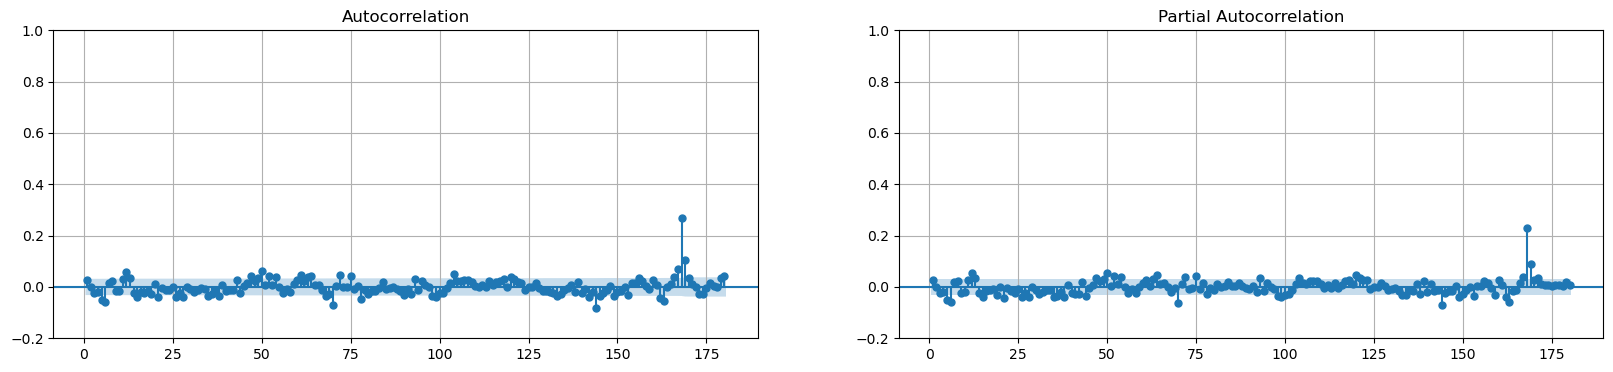

In [48]:
# Defining the Model
model = SARIMAX(
    endog = y_train,     
    order = (1, 0, 1), 
    seasonal_order = (1, 0, 1, 48)
    ).fit()
print(model.summary())

fig, axs = plt.subplots(ncols=2,figsize=(20,4))

# Plotting ACF and PACF 
tsaplots.plot_acf(model.resid, zero = False, lags = 180,  ax = axs[0])
tsaplots.plot_pacf(model.resid, zero = False, lags = 180, method='ywm', ax = axs[1])
for ax in axs:
    ax.grid(True)
    ax.set_ylim(-0.2,1)
plt.show()

ACF и PACF остатков SARIMA показывает, что на тренировочной выборке модель должна показывать неплохие результаты.

In [49]:
predict_train = pd.DataFrame(
    model.predict(
        start = y_train.index[0], 
        end = y_train.index[-1]))
train_rmse = RMSE(y_train.values, predict_train.values)
predict_test = pd.DataFrame(
    model.predict(
        start = y_test.index[0], 
        end = y_test.index[-1]))
test_rmse = RMSE(y_test.values, predict_test.values)
print(f'RMSE модели SARIMA на тренировочной выборке: {train_rmse:3.1f}')
print(f'RMSE модели SARIMA на тестовой выборке: {test_rmse:3.1f}')

RMSE модели SARIMA на тренировочной выборке: 23.0
RMSE модели SARIMA на тестовой выборке: 55.2


Таким образом, на тренировочной выборке удалось получить очень неплохой результат по RMSE - 22.1, но на тестовой результат неудовлетворительный - 55.2, что заметно и визуально на графиках ниже:

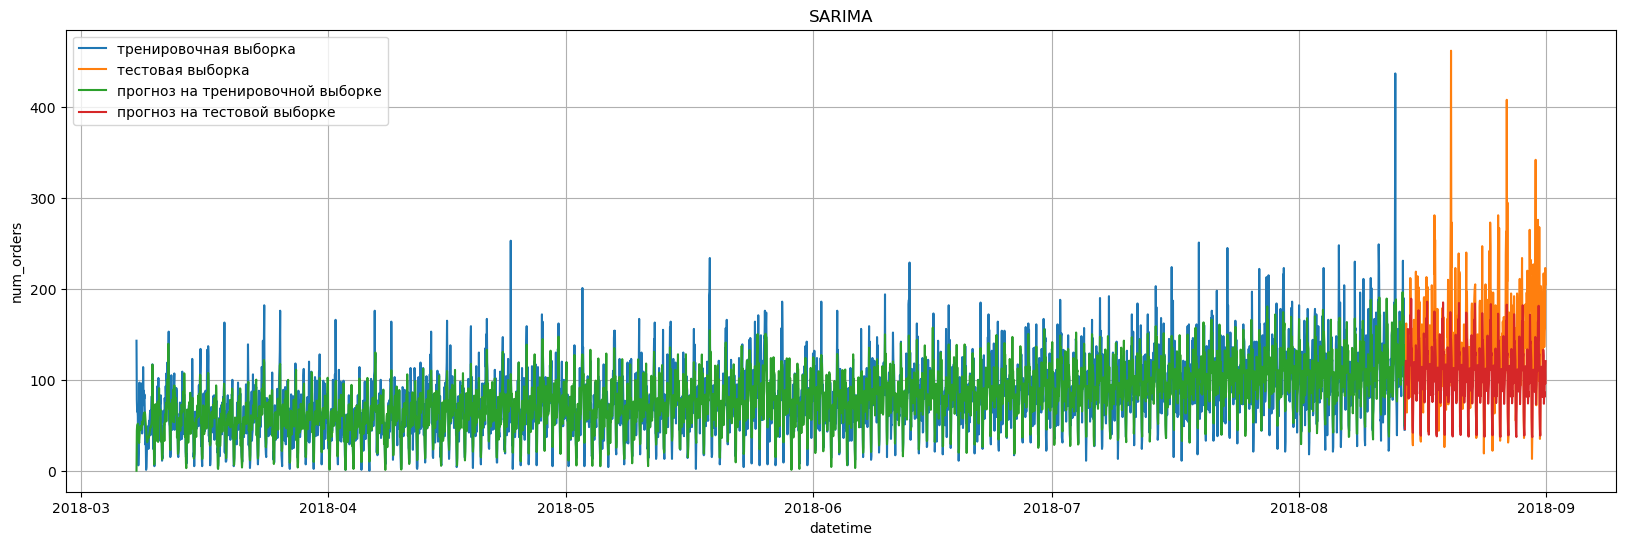

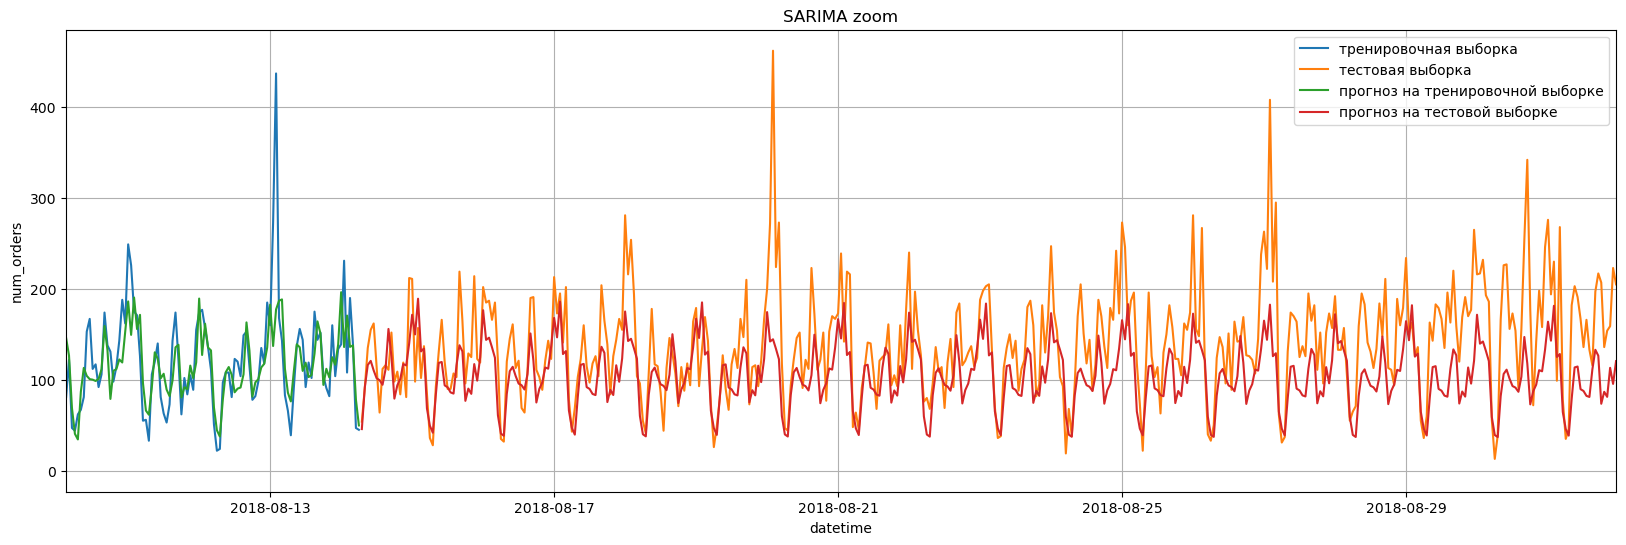

In [50]:
plot_forecast(y_train,y_test,predict_train, predict_test, 'SARIMA', zoom=True, xlim=[-100, -1])

### 4.3.3. <a id='toc4_3_3_'></a>[<font color='#42AAFF'>Оптимизация параметров модели</font>](#toc0_)

Подготовим функцию оптимизации параметров модели на кроссвалидационных выборках:

In [51]:
def opt_sarimax(x,y,folds,param_grid):
    
    pg = list(ParameterGrid(param_grid))
    test_errors = []
    best_score = 1e6
    best_parameters = []

    for a,b in enumerate(pg):        
        p = b.get('p')
        d = b.get('d')
        q = b.get('q')
        P = b.get('P')
        D = b.get('D')
        Q = b.get('Q')
        m = b.get('m')
        exog_list = b.get('exog_list')        
        # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
        tt_errors = []
        tr_errors = []      
        for tr, tt in folds.split(x):
            predict_train=[]
            predict_test=[]
            try:
                model = SARIMAX(
                    endog = y.iloc[tr], 
                    exog = x.iloc[tr][exog_list],
                    order = (p, d, q), 
                    seasonal_order = (P, D, Q, m)
                    ).fit()      

                predict_train = pd.DataFrame(
                    model.predict(
                        start = y.index[tr[0]], 
                        end =  y.index[tr[-1]],
                        exog = x.iloc[tr][exog_list]))

                tr_errors.append(RMSE(y.iloc[tr].values, predict_train.values))

                predict_test = pd.DataFrame(
                    model.predict(
                        start = y.index[tt[0]], 
                        end =  y.index[tt[-1]],
                        exog = x.iloc[tt][exog_list]))

                tt_errors.append(RMSE(y.iloc[tt].values, predict_test.values))   
            except:
                continue                     
        test_errors.append(np.mean(tt_errors))
        print(f'{b}: mean test RMSE  {np.mean(tt_errors):.1f} ({np.std(tt_errors):.1f}), {tt_errors}')
        #print(data.iloc[tr].shape)        
        if best_score > np.mean(tt_errors):
            best_score = np.mean(tt_errors)
            best_score_last = tt_errors[-1]
            best_parameters = b                
    print(
        f'best mean test RMSE: {best_score:.1f} \n'
        f'best model: {best_parameters}'
    )       
    return best_score, best_parameters, tr, tt

In [52]:
param_grid = {
                'p':    [1,2], 
                'd':    [0],
                'q':    [1,2],
                'P':    [1,2],
                'D':    [0],
                'Q':    [1,2],
                'm':    [24],            
            'exog_list': [['lag_48'],['lag_120'],['lag_168'],['lag_48','lag_168'],['lag_48','lag_120'],['lag_120','lag_168']]
            }
param_grid

{'p': [1, 2],
 'd': [0],
 'q': [1, 2],
 'P': [1, 2],
 'D': [0],
 'Q': [1, 2],
 'm': [24],
 'exog_list': [['lag_48'],
  ['lag_120'],
  ['lag_168'],
  ['lag_48', 'lag_168'],
  ['lag_48', 'lag_120'],
  ['lag_120', 'lag_168']]}

In [53]:
%%time
warnings.filterwarnings("ignore")
score, params_sarimax, tr_last, tt_last = opt_sarimax(x_train_sarimax, y_train, cv, param_grid)

{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'exog_list': ['lag_48'], 'm': 24, 'p': 1, 'q': 1}: mean test RMSE  31.7 (8.9), [21.644416843835863, 30.13520448146928, 43.38135614263407]
{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'exog_list': ['lag_48'], 'm': 24, 'p': 1, 'q': 2}: mean test RMSE  34.8 (6.1), [31.950906361428945, 29.15237811975515, 43.205892389236105]
{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'exog_list': ['lag_48'], 'm': 24, 'p': 2, 'q': 1}: mean test RMSE  34.6 (6.6), [31.97234418672266, 28.106643521445836, 43.677378001811704]
{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'exog_list': ['lag_48'], 'm': 24, 'p': 2, 'q': 2}: mean test RMSE  35.8 (6.4), [31.96866110355245, 30.576355858693, 44.836834791815015]
{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'exog_list': ['lag_120'], 'm': 24, 'p': 1, 'q': 1}: mean test RMSE  28.8 (10.0), [21.78719520013057, 21.622508783838544, 42.89261193778244]
{'D': 0, 'P': 1, 'Q': 1, 'd': 0, 'exog_list': ['lag_120'], 'm': 24, 'p': 1, 'q': 2}: mean test RMSE  28.4 (9.6), [21.735132833101922, 21.525347

RMSE модели SARIMAX на тренировочной выборке: 23.3
RMSE модели SARIMAX на тестовой выборке: 41.7


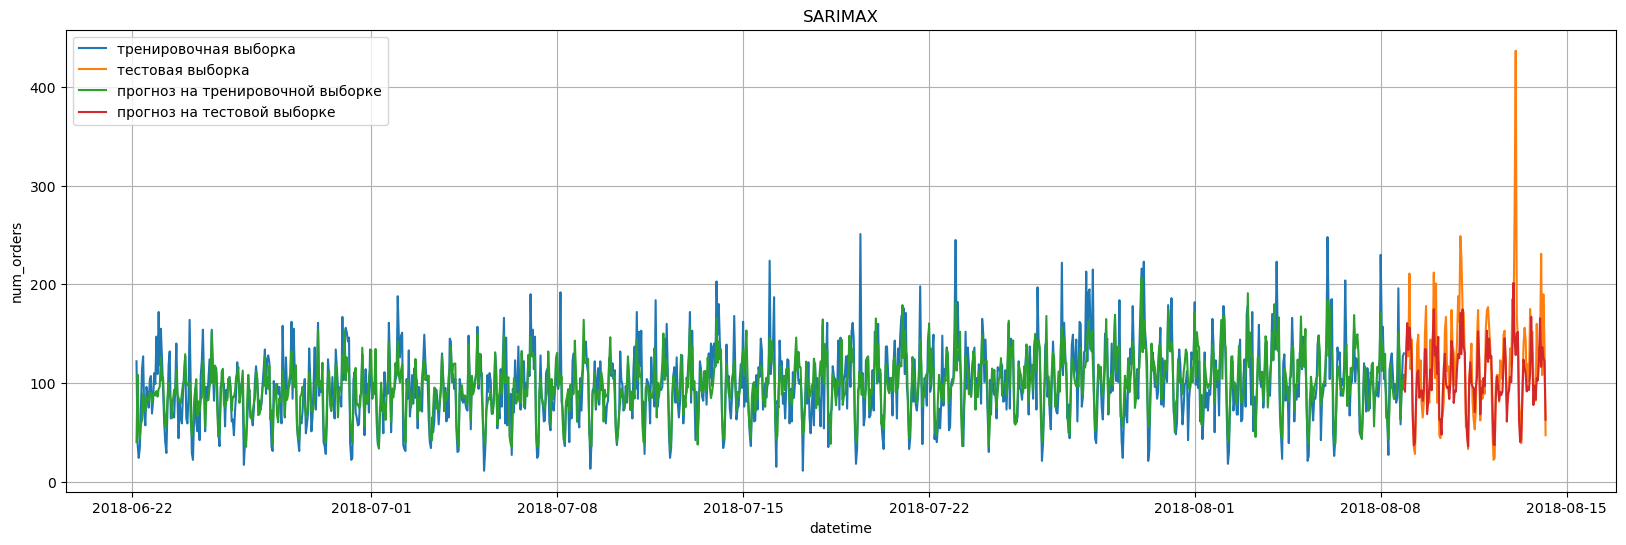

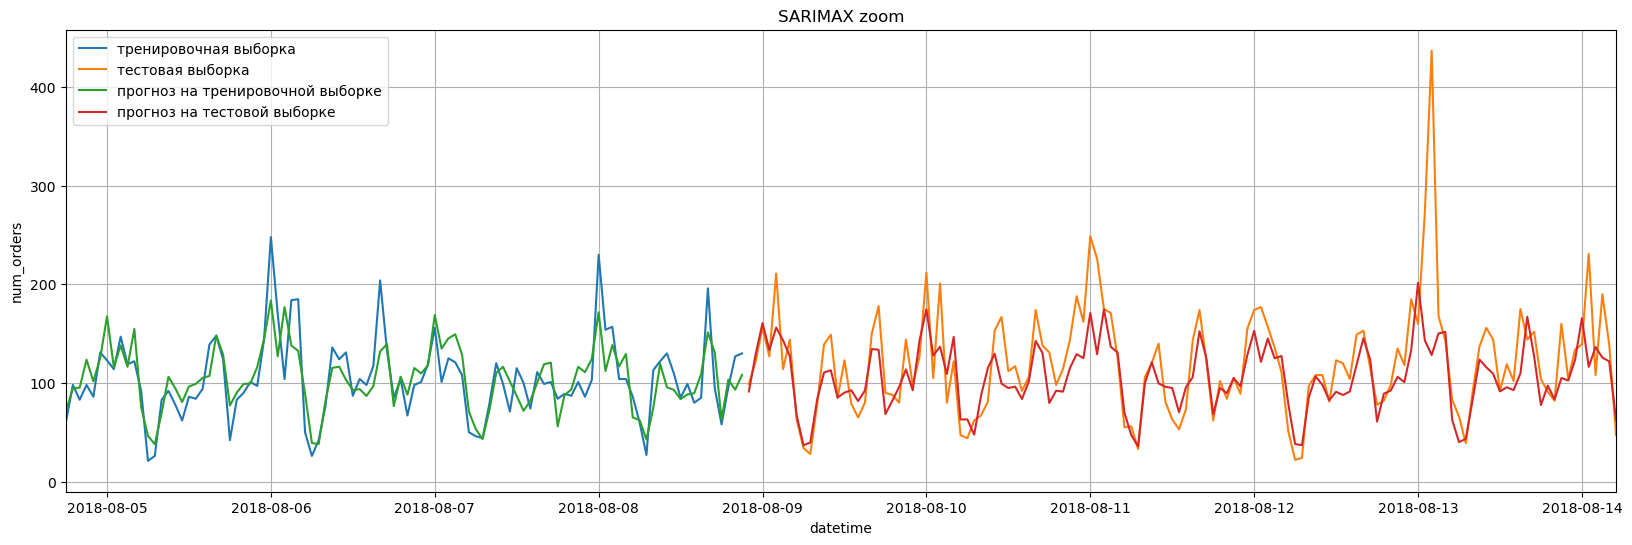

In [58]:
# Defining the Model
model = SARIMAX(
    endog = y_train.iloc[tr_last],     
    exog = x_train_sarimax.iloc[tr_last][['lag_168']],
    order = (2,0,2), 
    seasonal_order = (2,0,1,24)
    ).fit()
#print(model.summary())


predict_train = pd.DataFrame(
    model.predict(
        start = y_train.index[tr_last[0]], 
        end = y_train.index[tr_last[-1]],
        exog = x_train_sarimax.iloc[tr_last][['lag_168']]))


sarima_train_rmse = RMSE(y_train.iloc[tr_last].values, predict_train.values)


predict_test = pd.DataFrame(
    model.predict(
        start = y_train.index[tt_last[0]], 
        end = y_train.index[tt_last[-1]],
        exog = x_train_sarimax.iloc[tt_last][['lag_168']]))
 
sarima_test_rmse = RMSE(y_train.iloc[tt_last].values, predict_test.values)

print(f'RMSE модели SARIMAX на тренировочной выборке: {sarima_train_rmse:3.1f}')
print(f'RMSE модели SARIMAX на тестовой выборке: {sarima_test_rmse:3.1f}')
plot_forecast(y_train.iloc[tr_last],y_train.iloc[tt_last],predict_train, predict_test, 'SARIMAX', zoom=True, xlim=[-100, -1])

In [59]:
model = SARIMAX(
    endog = y_train,     
    exog = x_train_sarimax[['lag_168']],
    order = (2,0,2), 
    seasonal_order = (2,0,1,24))
dump(model, 'sarimax.joblib')  

['sarimax.joblib']

### 4.3.4. <a id='toc4_3_4_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Построенная на основе анализа ACF, PACF модель SARIMA не позволяет в данном случае получить удовлетворительный результат на тестовой выборке кроссвалидации.
2. Добавление X факторов периодичности (2х суточный и недельный лаг) в SARIMAX позволило получить удовлетворительные резутаты на кроссвалидационных тестовых выборках.

## 4.4. <a id='toc4_4_'></a>[<font color='#42AAFF'>Линейная регрессия</font>](#toc0_)

### 4.4.1. <a id='toc4_4_1_'></a>[<font color='#42AAFF'>Функции</font>](#toc0_)

Функция усреднения по группе:

In [60]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Функция подготовки данных:
1. Авторегрессионные признаки.
2. Усредненные признаки. Средние рассчитываются только по тренировочной выборке.
3. Стандартизация признаков. Обучение выполняется только на тренировочной выборке.

In [61]:
def prepare_data(data, lags, test_ratio=0.1):

    data = pd.DataFrame(data.copy())
       
   # добавляем лаги исходного ряда в качестве признаков
    for ll in lags:
        data['lag_{}'.format(ll)] = data[data.columns[0]].shift(ll)

    data = data.dropna()
    #data = data.reset_index(drop=True)           
    
    #data.index = data.index.to_datetime()
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    margin_index = int(len(data)*(1-test_ratio))

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data.iloc[:margin_index], 'weekday', data.columns[0]).get, data.weekday))
    data['hour_average'] = list(map(code_mean(data.iloc[:margin_index], 'hour', data.columns[0]).get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(['hour', 'weekday'], axis=1, inplace=True)


    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    x_train = data.iloc[:margin_index].drop([data.columns[0]], axis=1)
    y_train = data.iloc[:margin_index][[data.columns[0]]]
    x_test = data.iloc[margin_index:].drop([data.columns[0]], axis=1)
    y_test = data.iloc[margin_index:][[data.columns[0]]]

    # стандартизируем выборки
    #отключаем вывод предупреждения SettingWithCopy
    pd.options.mode.chained_assignment = None
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train[x_train.columns] = scaler.transform(x_train)
    x_test[x_test.columns] = scaler.transform(x_test)

    return x_train, y_train, x_test, y_test

Функция определения VIF (Variance Inflation Factor):

In [62]:
def variance_inflation_factors(x):
    model = LinearRegression()
    vif = pd.DataFrame(columns=['features','vif'])
    for i in range(x.shape[1]):        
        x_i = x.drop(x.columns[i], axis=1)
        y_i = x[x.columns[i]]
        model_i = model.fit(x_i, y_i)
        y_i_pred = model_i.predict(x_i)        
        r2_i = r2_score(y_i, y_i_pred)        
        vif_i = 1 / (1 - r2_i)
        vif.loc[i,'features'] = x.columns[i]
        vif.loc[i,'vif'] = vif_i
        vif = vif.sort_values(by='vif',ascending=False).reset_index(drop=True)
    return vif

Рекурсивная функция для итерационного исключения признаков с VIF>5:

In [63]:
def mc_exclude_iterative(x):
    vif = variance_inflation_factors(x)    
    if vif.loc[0,'vif']>5:              
        vif = mc_exclude_iterative(x.drop(vif.loc[0,'features'], axis=1))
    return vif

Функция визуализации зависимости метрики от числа признаков по результатам RFE анализа:

In [64]:
def RFE_res_plot(cv_results, score_name):
    cv_results = cv_results.copy()
    cols_test = list(cv_results.columns)[list(cv_results.columns).index('params')+1:list(cv_results.columns).index('mean_test_score')]
    cols_train = list(cv_results.columns)[list(cv_results.columns).index('rank_test_score')+1:list(cv_results.columns).index('mean_train_score')]
    pivot_df = pd.DataFrame(columns=['n_features', score_name,'sample'])
    pivot_df['n_features'] = list(cv_results['param_n_features_to_select'])*2*len(cols_test)
    pivot_df['sample'] = (['train']*len(cv_results['param_n_features_to_select'])+['test']*len(cv_results['param_n_features_to_select']))*len(cols_test)
    score = cv_results[cols_train[0]]
    score = pd.concat([score, cv_results[cols_test[0]]],ignore_index=True)
    for ind in range(1,len(cols_test)):
        score = pd.concat([score, cv_results[cols_train[ind]]],ignore_index=True)
        score = pd.concat([score, cv_results[cols_test[ind]]],ignore_index=True)    
    pivot_df[score_name] = abs(score)
    fig, axs = plt.subplots(figsize=(10,6))
    sns.lineplot(data=pivot_df,x='n_features',y=score_name,hue='sample',ci='sd',ax=axs)
    axs.grid(True)
    axs.set(title=f'Зависимость {score_name} от количества независимых признаков в модели')
    plt.show()
    return

Выберем иное разбиение выборок для кроссвалидации:

In [65]:
cv = BlockingTimeSeriesSplit(n_splits=5, size_ratio=0.75)

Подготовим признаки на основе исходного временного ряда для дальнейшего анализа:

In [66]:
x_train, y_train, x_test, y_test = prepare_data(data_1H, [2,4,6,8,12,24,48,168])

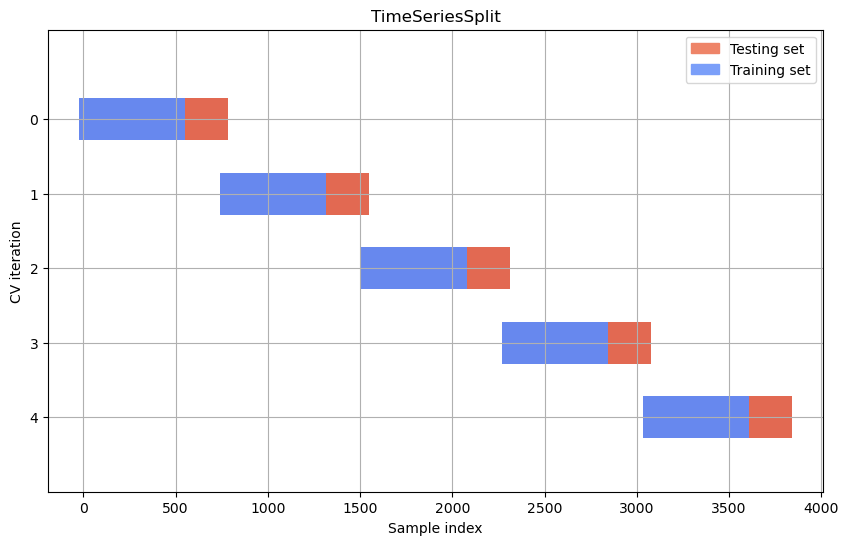

In [67]:
split_plot(cv,x_train)

Проверим, что признаки немультиколлинеарны (считаем их таковыми если Variance Inflation Factor <5):

In [68]:
variance_inflation_factors(x_train)

features       vif
0      hour_average  2.857067
1           lag_168  2.554972
2            lag_48  2.517701
3            lag_24  2.396193
4             lag_4    1.4401
5             lag_6  1.377833
6             lag_2  1.366515
7             lag_8  1.263632
8            lag_12   1.19101
9   weekday_average  1.112608
10       is_weekend  1.039272

Используя оценку RFE, исключим несущественные признаки по метрике RMSE с применением кроссвалидации:

In [69]:
%%time
params = [{'n_features_to_select': list(range(1, 11))}]
#определяем модель
model = LinearRegression()
model.fit(x_train, y_train)
rfe = RFE(model)  
#оптимизируем модель с помощью GridSearchCV по количеству отобранных признаков
model_cv = GridSearchCV(
    estimator = rfe, 
    param_grid = params, 
    scoring= make_scorer(RMSE,greater_is_better=False), 
    cv = cv, 
    verbose = 0,
    return_train_score=True)  
model_cv.fit(x_train, y_train)
cv_results = pd.DataFrame(model_cv.cv_results_)

Wall time: 710 ms


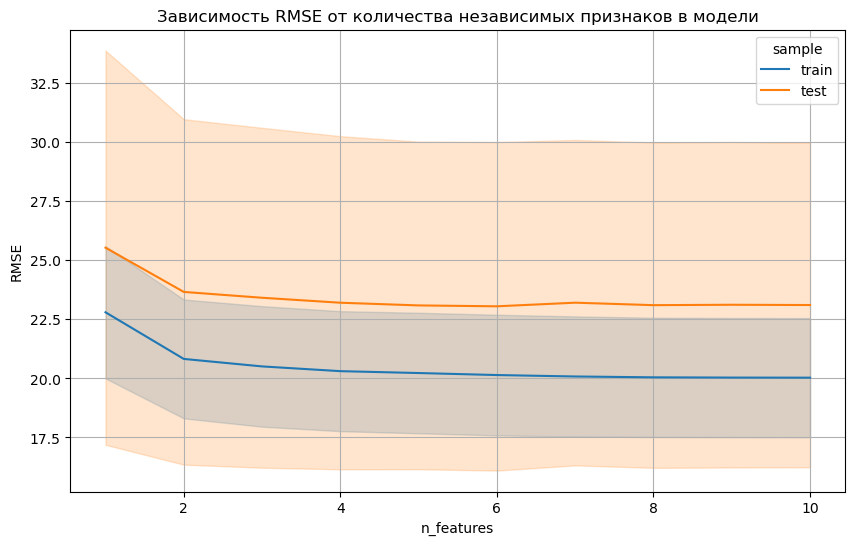

In [70]:
RFE_res_plot(cv_results, 'RMSE')

По графику можно сделать следующие выводы:
1. Даже при 1 признаке средний RMSE на тестовой выборке несколько выше 25 при стандартном отклонении ~ 34.
2. RMSE (и ее стандартное отклонение) монотонно уменьшается по мере увеличение числа признаков, при этом наиболее существенное изменение происходит при увеличении с 1 до 2 признаков, причем это изменение незначительно - менее 10%.
3. Увеличение числа признаков свыше 5 не приводит к улучшению метрики.

In [71]:
n_features_optimal = 4
rfe = RFE(model, n_features_to_select=n_features_optimal)   
rfe = rfe.fit(x_train, y_train)
model = rfe.estimator_
dump(model,'linreg_v01.joblib')

['linreg_v01.joblib']

Так как признаки были предварительно стандартизированы, то по коэффициентам линейной регрессии можно судить о степени влияния признака. Как видно из таблицы ниже наибольшее влияние имеют авторегрессионные признаки с недельным, суточным и 2х суточным лагом.

In [72]:
coeff = pd.DataFrame(columns=['feature','coeff'])
coeff['feature'] = list(rfe.get_feature_names_out())
coeff['coeff'] = model.coef_[0]
coeff

feature      coeff
0        lag_24   6.191979
1        lag_48   7.892451
2       lag_168  17.836106
3  hour_average   4.306983

Построим прогноз модели для одной из кроссвалидационных выборок и визуализируем результат:

In [73]:
x_train_cv_last = x_train.iloc[int(len(x_train)/cv.n_splits*(cv.n_splits-1)):int(len(x_train)-len(x_train)/cv.n_splits*(1-cv.size_ratio))]
y_train_cv_last = y_train.iloc[int(len(y_train)/cv.n_splits*(cv.n_splits-1)):int(len(y_train)-len(y_train)/cv.n_splits*(1-cv.size_ratio))]
x_test_cv_last = x_train.iloc[int(len(x_train)-len(x_train)/cv.n_splits*(1-cv.size_ratio)):]
y_test_cv_last = y_train.iloc[int(len(y_train)-len(y_train)/cv.n_splits*(1-cv.size_ratio)):]

RMSE на тренировочной выборке: 24.6
RMSE на тестовой выборке: 35.5


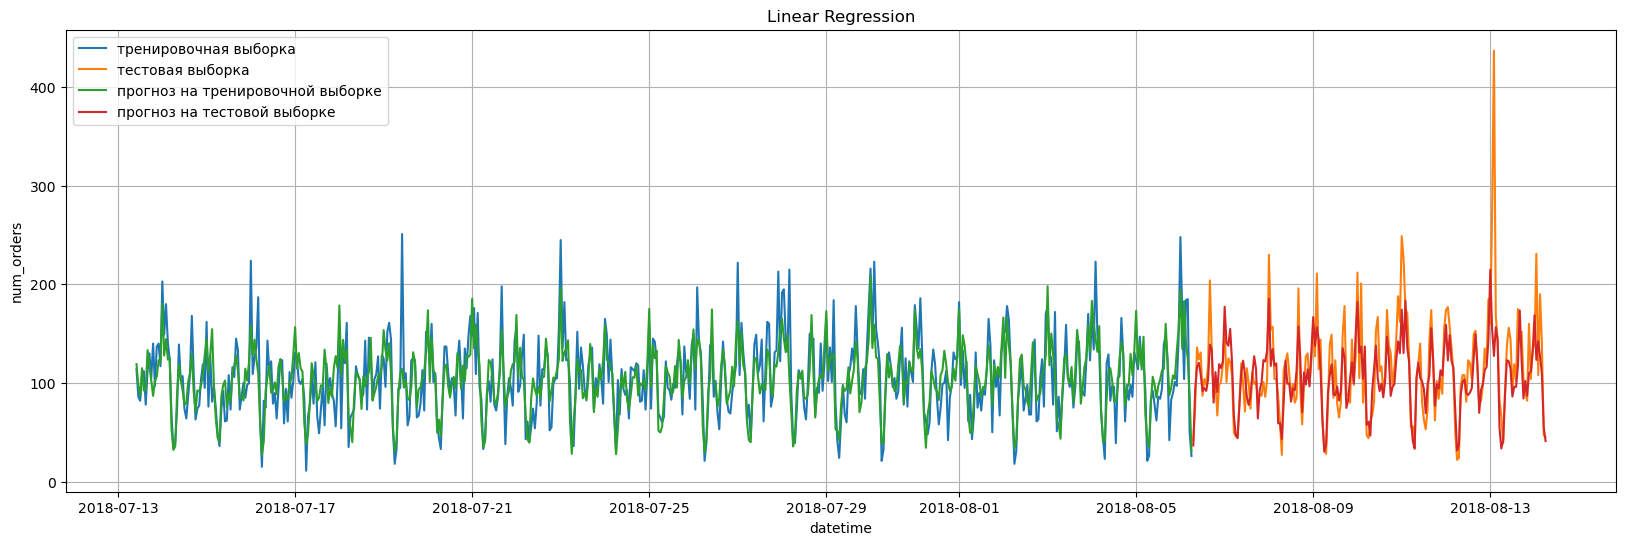

In [74]:
model.fit(x_train_cv_last[coeff['feature']].values,y_train_cv_last)
pred_train = pd.DataFrame(model.predict(x_train_cv_last[coeff['feature']].values),index=x_train_cv_last.index)
pred_test = pd.DataFrame(model.predict(x_test_cv_last[coeff['feature']].values),index=x_test_cv_last.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train_cv_last, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test_cv_last, pred_test):0.1f}')
plot_forecast(y_train_cv_last, y_test_cv_last, pred_train, pred_test, 'Linear Regression')

Получили удовлетворительное качество модели на тестовых кроссвалидационных выборках, при этом время обучения очень низкое, что выгодно отличает линейную регрессию от экспоненциальных моделей.

## 4.5. <a id='toc4_5_'></a>[<font color='#42AAFF'>CatBoost</font>](#toc0_)

In [75]:
%%time
est = CatBoostRegressor()
params = {
    'iterations': [20, 50, 100],
    'depth': [4,6,8,10,12],
    #'learning_rate' : [0.5]
    }
#оптимизируем модель с помощью GridSearchCV
model_cv = GridSearchCV(
    estimator = est, 
    param_grid = params, 
    scoring = make_scorer(RMSE,greater_is_better=False), 
    n_jobs = -1,
    cv = cv, 
    verbose = 0
    )
model_cv.fit(x_train, y_train,verbose=False)
cv_results = pd.DataFrame(model_cv.cv_results_)
model = model_cv.best_estimator_
print(f'Лучшая модель \n',
      f'Параметры модели: {model_cv.best_params_} \n',
      f'Усредненная оценка RMSE для наилучшей модели: {np.abs(model_cv.best_score_):.1f} \n',
      f'Время обучения на тренировочной выборке: {model_cv.refit_time_:4.2f}'                
      ) 
dump(model, 'catboost.joblib')  

Лучшая модель 
 Параметры модели: {'depth': 4, 'iterations': 100} 
 Усредненная оценка RMSE для наилучшей модели: 23.6 
 Время обучения на тренировочной выборке: 0.41
Wall time: 52.2 s


['catboost.joblib']

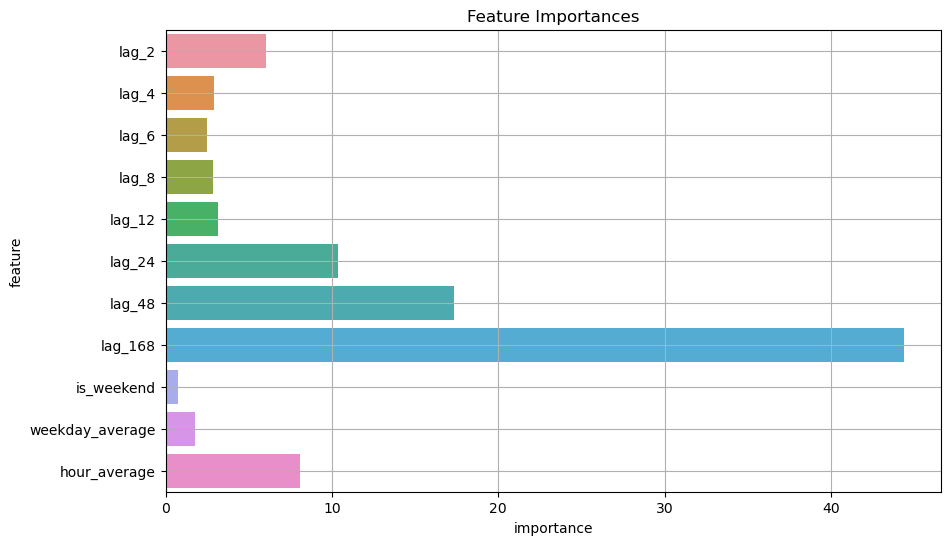

In [76]:
feature_importances = pd.DataFrame(columns=['feature','importance'])
feature_importances['feature'] = list(x_train.columns)
feature_importances['importance'] = model.feature_importances_
fig, axs = plt.subplots(figsize=(10,6))
sns.barplot(data=feature_importances,x='importance',y='feature',orient='h',ax=axs)
axs.grid(True)
axs.set(title=f'Feature Importances')
plt.show()

Построим прогноз модели для одной из кроссвалидационных выборок и визуализируем результат:

RMSE на тренировочной выборке: 15.8
RMSE на тестовой выборке: 35.2


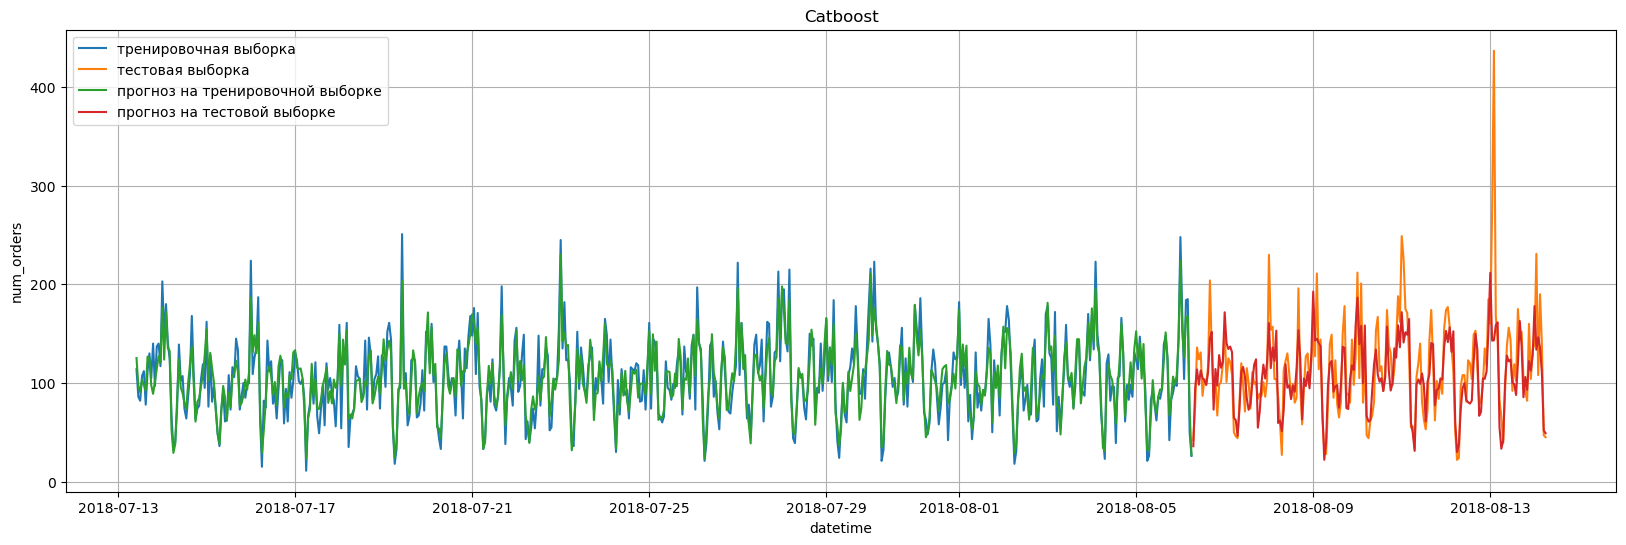

In [77]:
model.fit(x_train_cv_last.values,y_train_cv_last,verbose=False)
pred_train = pd.DataFrame(model.predict(x_train_cv_last.values),index=x_train_cv_last.index)
pred_test = pd.DataFrame(model.predict(x_test_cv_last.values),index=x_test_cv_last.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train_cv_last, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test_cv_last, pred_test):0.1f}')
plot_forecast(y_train_cv_last, y_test_cv_last, pred_train, pred_test, 'Catboost')

Catboost показывает хороший результат на кроссвалидационных тестовых выборках. Интересно, что как и в случае с линейной регрессией сильнее всего влияют на результат теже признаки.

## 4.6. <a id='toc4_6_'></a>[<font color='#42AAFF'>XGBoost</font>](#toc0_)

In [78]:
%%time
est = xgb.XGBRegressor()
params = {
    'max_depth': [4,6,8,10,12,14,16],
    'n_estimators':[10, 50, 100],
    'learning_rate' : [0.5]
    }
#оптимизируем модель с помощью GridSearchCV
model_cv = GridSearchCV(
    estimator = est, 
    param_grid = params, 
    scoring = make_scorer(RMSE,greater_is_better=False), 
    n_jobs = -1,
    cv = cv, 
    verbose = 0
    )
model_cv.fit(x_train.values, y_train,verbose=False)
cv_results = pd.DataFrame(model_cv.cv_results_)
model = model_cv.best_estimator_
print(f'Лучшая модель \n',
      f'Параметры модели: {model_cv.best_params_} \n',
      f'Усредненная оценка RMSE для наилучшей модели: {np.abs(model_cv.best_score_):.1f} \n',
      f'Время обучения на тренировочной выборке: {model_cv.refit_time_:4.2f}'                
      ) 
dump(model, 'xgboost.joblib')  

Лучшая модель 
 Параметры модели: {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 10} 
 Усредненная оценка RMSE для наилучшей модели: 24.7 
 Время обучения на тренировочной выборке: 0.02
Wall time: 4.18 s


['xgboost.joblib']

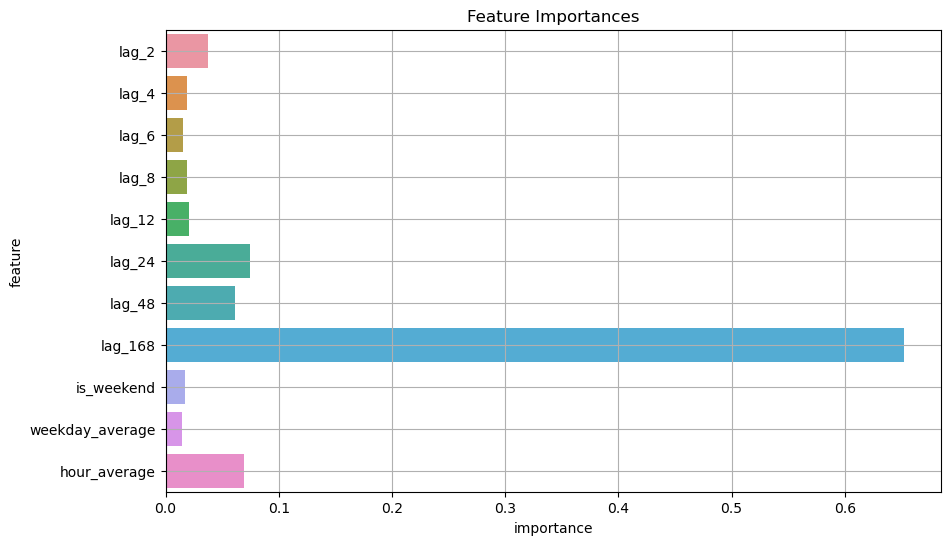

In [79]:
feature_importances = pd.DataFrame(columns=['feature','importance'])
feature_importances['feature'] = list(x_train.columns)
feature_importances['importance'] = model.feature_importances_
fig, axs = plt.subplots(figsize=(10,6))
sns.barplot(data=feature_importances,x='importance',y='feature',orient='h',ax=axs)
axs.grid(True)
axs.set(title=f'Feature Importances')
plt.show()

Построим прогноз модели для одной из кроссвалидационных выборок и визуализируем результат:

RMSE на тренировочной выборке: 15.4
RMSE на тестовой выборке: 36.5


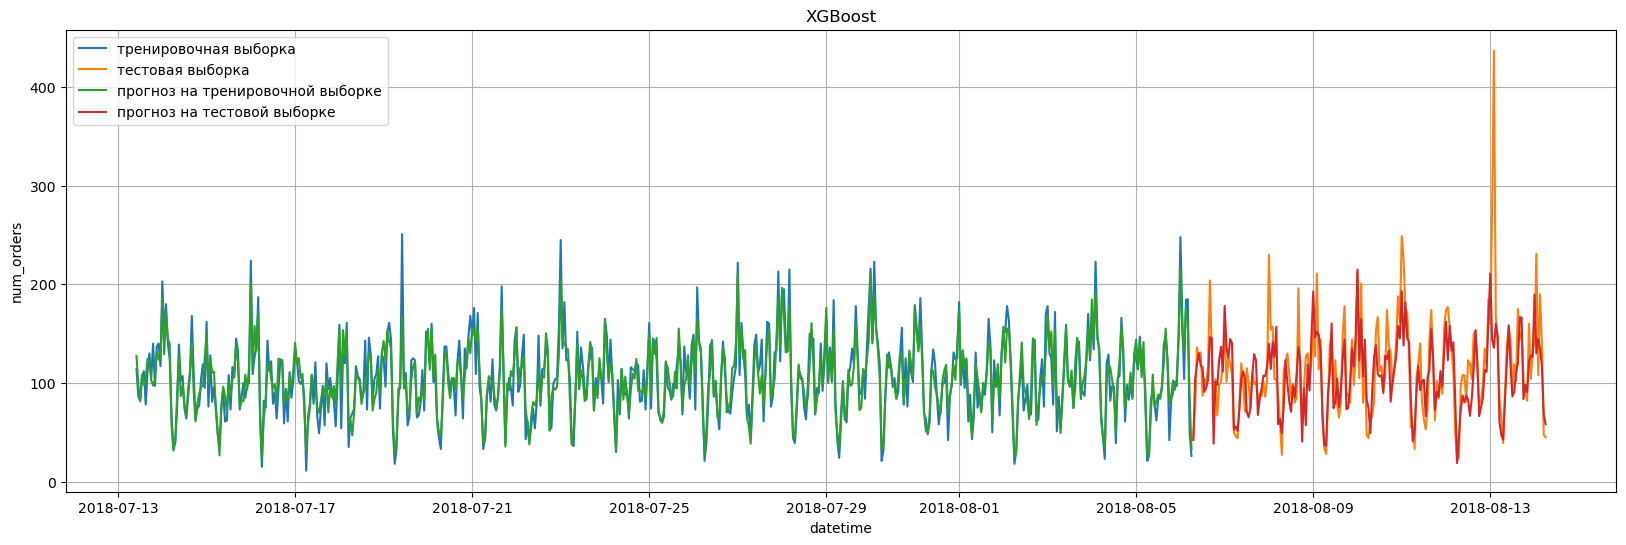

In [80]:
model.fit(x_train_cv_last.values,y_train_cv_last,verbose=False)
pred_train = pd.DataFrame(model.predict(x_train_cv_last.values),index=x_train_cv_last.index)
pred_test = pd.DataFrame(model.predict(x_test_cv_last.values),index=x_test_cv_last.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train_cv_last, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test_cv_last, pred_test):0.1f}')
plot_forecast(y_train_cv_last, y_test_cv_last, pred_train, pred_test, 'XGBoost')

Любопытно, что XGBoost выделяет теже 4 наиболее сильно вляющих признака, что и CatBoost, и линейная регрессия, но при этом степень влияния этих признаков существенно отличается.

## 4.7. <a id='toc4_7_'></a>[<font color='#42AAFF'>LightGBM</font>](#toc0_)

In [81]:
%%time
est = lgb.LGBMRegressor()
params = {
    'n_estimators':[10,50,100],
    'num_leaves': list(range(10,100,10)),
    #'min_data_in_leaf': [20,200,20],
    'max_depth': [4,6,8,10,12,14,16]  
    }
#оптимизируем модель с помощью GridSearchCV
model_cv = GridSearchCV(
    estimator = est, 
    param_grid = params, 
    scoring = make_scorer(RMSE,greater_is_better=False), 
    n_jobs = -1,
    cv = cv, 
    verbose = 0
    )
model_cv.fit(x_train.values, y_train[y_train.columns[0]],verbose=False)
cv_results = pd.DataFrame(model_cv.cv_results_)
model = model_cv.best_estimator_
print(f'Лучшая модель \n',
      f'Параметры модели: {model_cv.best_params_} \n',
      f'Усредненная оценка RMSE для наилучшей модели: {np.abs(model_cv.best_score_):.1f} \n',
      f'Время обучения на тренировочной выборке: {model_cv.refit_time_:4.2f}'                
      ) 
dump(model, 'lgbm.joblib')  

Лучшая модель 
 Параметры модели: {'max_depth': 4, 'n_estimators': 50, 'num_leaves': 10} 
 Усредненная оценка RMSE для наилучшей модели: 23.4 
 Время обучения на тренировочной выборке: 0.03
Wall time: 18.6 s


['lgbm.joblib']

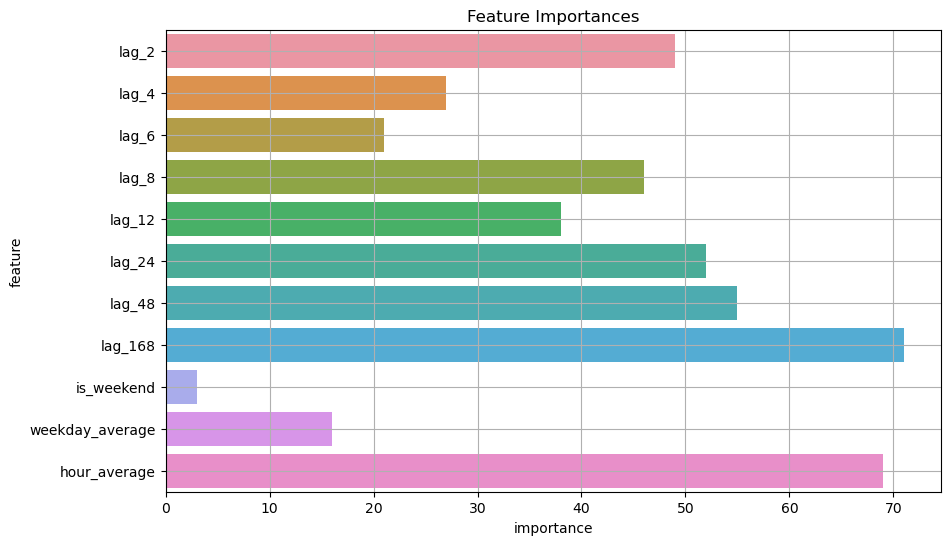

In [82]:
feature_importances = pd.DataFrame(columns=['feature','importance'])
feature_importances['feature'] = list(x_train.columns)
feature_importances['importance'] = model.feature_importances_
fig, axs = plt.subplots(figsize=(10,6))
sns.barplot(data=feature_importances,x='importance',y='feature',orient='h',ax=axs)
axs.grid(True)
axs.set(title=f'Feature Importances')
plt.show()

RMSE на тренировочной выборке: 18.6
RMSE на тестовой выборке: 34.6


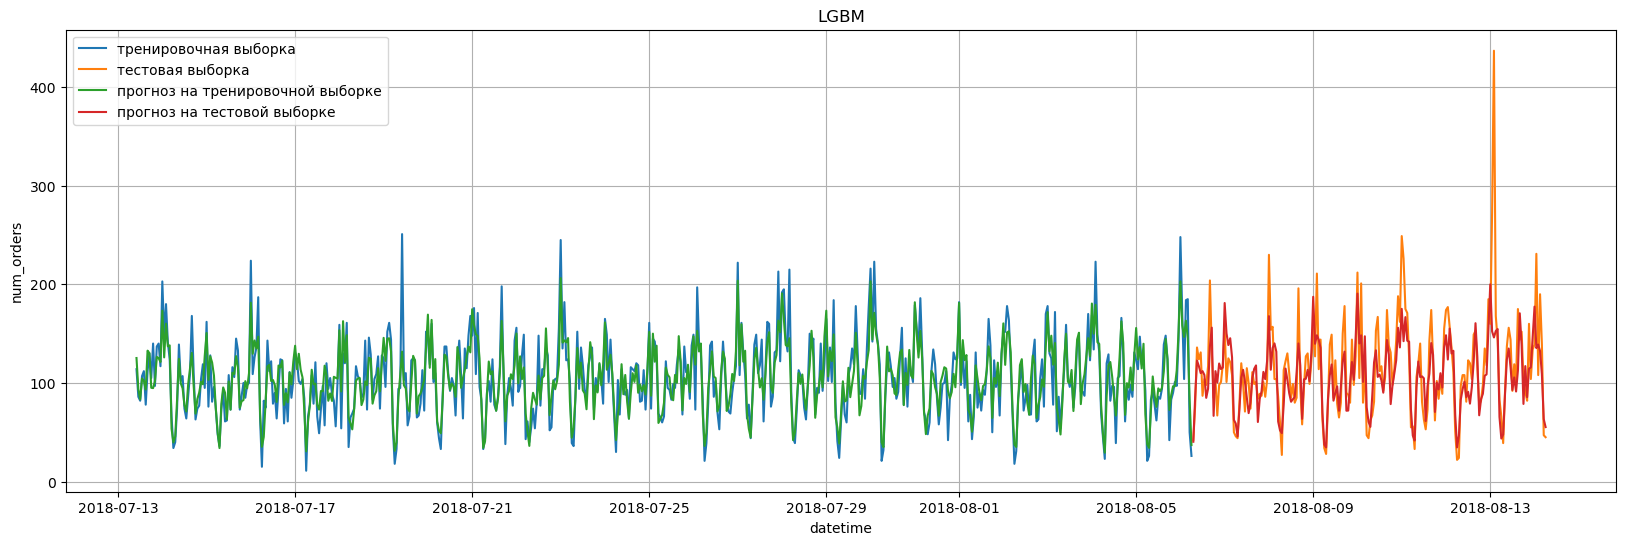

In [83]:
model.fit(x_train_cv_last.values,y_train_cv_last[y_train_cv_last.columns[0]],verbose=False)
pred_train = pd.DataFrame(model.predict(x_train_cv_last.values),index=x_train_cv_last.index)
pred_test = pd.DataFrame(model.predict(x_test_cv_last.values),index=x_test_cv_last.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train_cv_last, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test_cv_last, pred_test):0.1f}')
plot_forecast(y_train_cv_last, y_test_cv_last, pred_train, pred_test, 'LGBM')

Получили относительно неплохой результат на кроссвалидации, но при этом важность признаков кардинально отличается от всех ранее рассмотренных моделей.

## 4.8. <a id='toc4_8_'></a>[<font color='#42AAFF'>Выводы</font>](#toc0_)

1. Подготовили вспомогательные функции:
    - блочного разбиения временного ряда для проведения кроссвалидации
    - визуализации кроссвалидационных выборок
    - визуализации прогнозов моделей
    - оптимизации параметров экспоненциальных моделей на кроссвалидации
    - прогноза для экспоненциальных моделей
    - подготовки данных для моделей линейной регрессии и бустингов
    - определения VIF для проверки мультиколлинеарности признаков
    - рекурсивного исключения мультиколлинеарных факторов
    - визуализации зависимости среднего значения метрики по кроссвалидационным выборкам от числа признаков    
2. Обучили экспоненциальные модели Simple Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing:
    - выбрали кроссвалидационные выборки
    - оптимизировали параметры каждой из моделей на кроссвалидационных выборках
    - визуализировали прогноз на тренировочной и тестовой кроссвалидационной выборке
    - получили значения RMSE, только Triple Exponential Smoothing имеет некоторые шансы уложиться в требования по RMSE=48 на тестовой выборке
3. Обучили модель SARIMAX:
    - подготовили лаги для использования в качестве X факторов 
    - выбрали кроссвалидационные выборки    
    - оптимизировали параметры каждой из моделей на кроссвалидационных выборках
    - визуализировали прогноз на тренировочной и тестовой кроссвалидационной выборке
    - получили среднее значение на тестовых выборках RMSE = 27.5     
4. Обучили модель линейной регрессии:
    - выбрали кроссвалидационные выборки
    - убедились, что выбранные признаки неколлинеарны
    - на кроссвалидационных выборках оптимизировали количество признаков: сильнее всего на метрику влияет недельный лаг, также имеют существенное влияние 1 и 2х суточные лаги и почасовое усреднение
    - среднее RMSE на тестовых выборках примерно равно 35, но наблюдался существенный разброс метрики.
5. Обучили бустинговые модели: CatBoost, XGBoost, LightGBM:
    - оптимизировали гиперпараметры моделей на кроссвалидации
    - оптимизированные модели показали удовлетворительные прогнозы на тестовых выборках с RMSE ~ 35
    - любопытно, что важность признаков бустинговые модели оценивают по-разному - выделяют те же 4 наиболее сильно влияющие признаки, что и линейная регрессия, но количественно по-разному оценивают степень их важности.

# 5. <a id='toc5_'></a>[<font color='#42AAFF'>Тестирование</font>](#toc0_)

## 5.1. <a id='toc5_1_'></a>[<font color='#42AAFF'>Экспоненциальные модели</font>](#toc0_)

Рассмотрим прогноз простого экспоненциального сглаживания:

In [84]:
predict_train, predict_test = predict_ExpSm(train, test, params_ses)

RMSE на тренировочной выборке: 34.7
RMSE на тестовой выборке: 63.2


Визализируем прогноз на тестовой выборке:

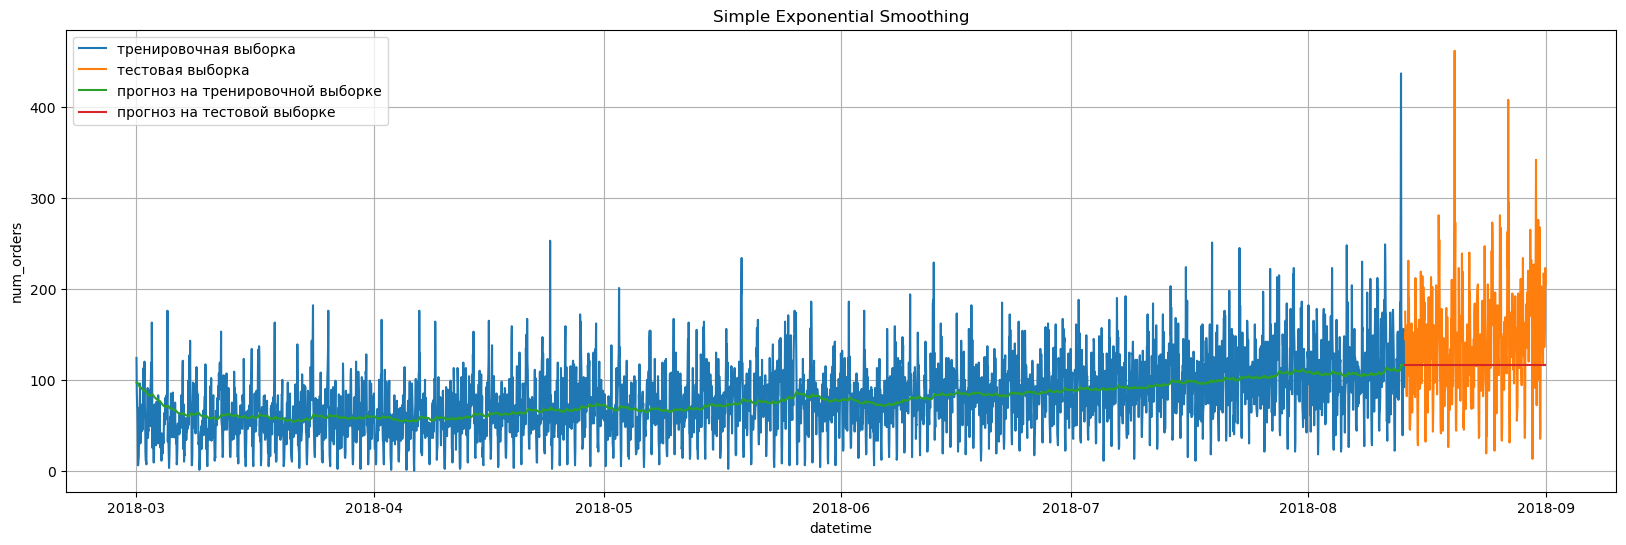

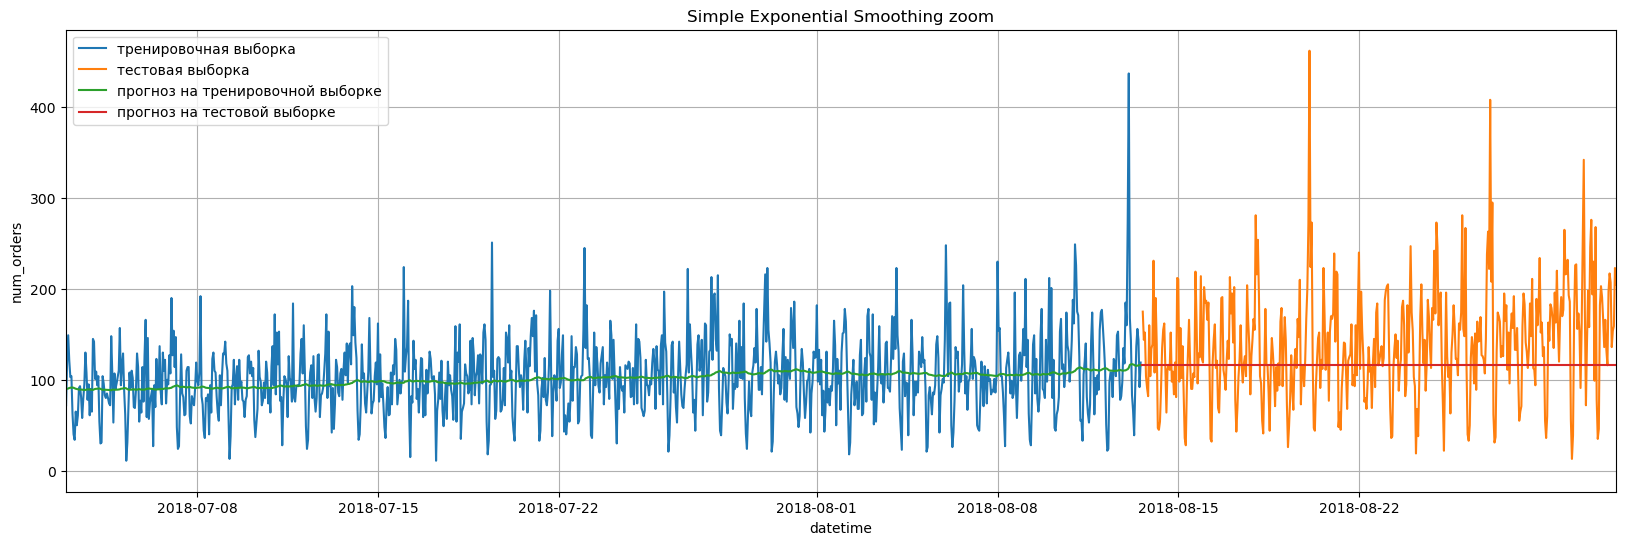

In [85]:
plot_forecast(train, test, predict_train, predict_test, 'Simple Exponential Smoothing',zoom=True,xlim=[-1000,-1])

Уровень тестовой выборки существенно изменяется в процессе и имеются выбросы, что приводит к недостаточно низкому значению метрики.

Рассмотрим прогноз двойного экспоненциального сглаживания (Double Exponential Smoothing):

In [86]:
predict_train, predict_test = predict_ExpSm(train, test, params_des)

RMSE на тренировочной выборке: 132.7
RMSE на тестовой выборке: 59.0


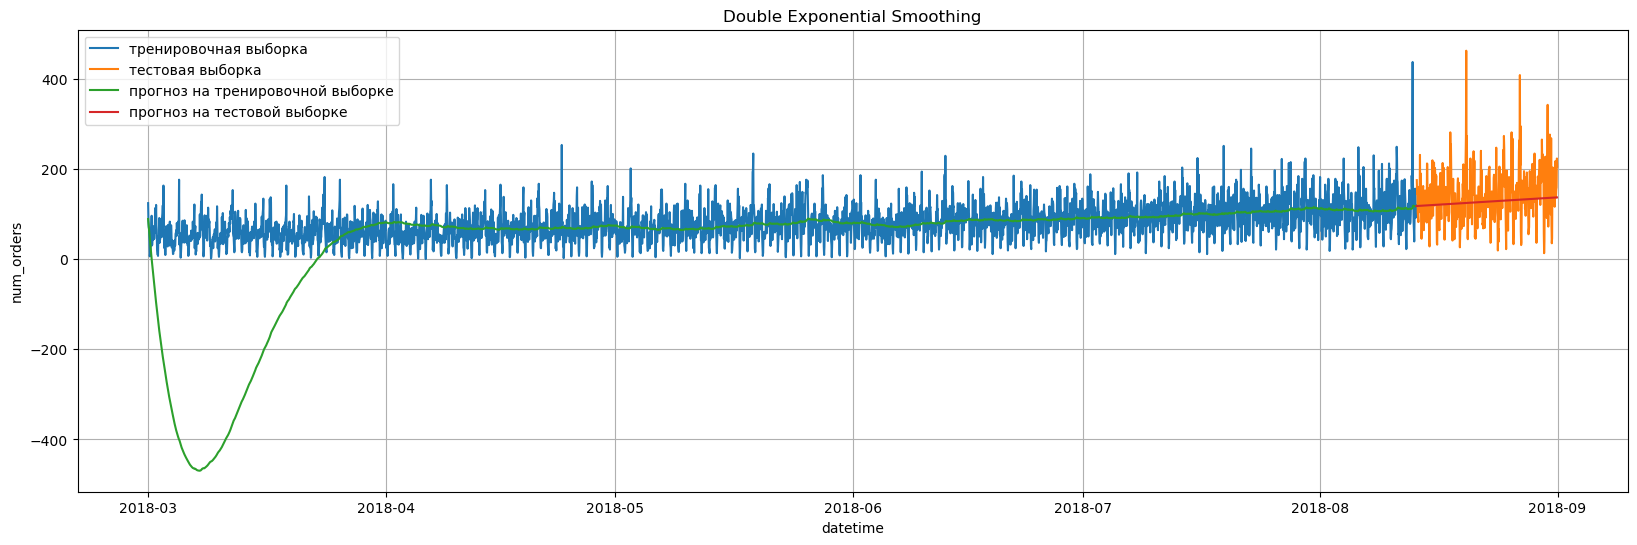

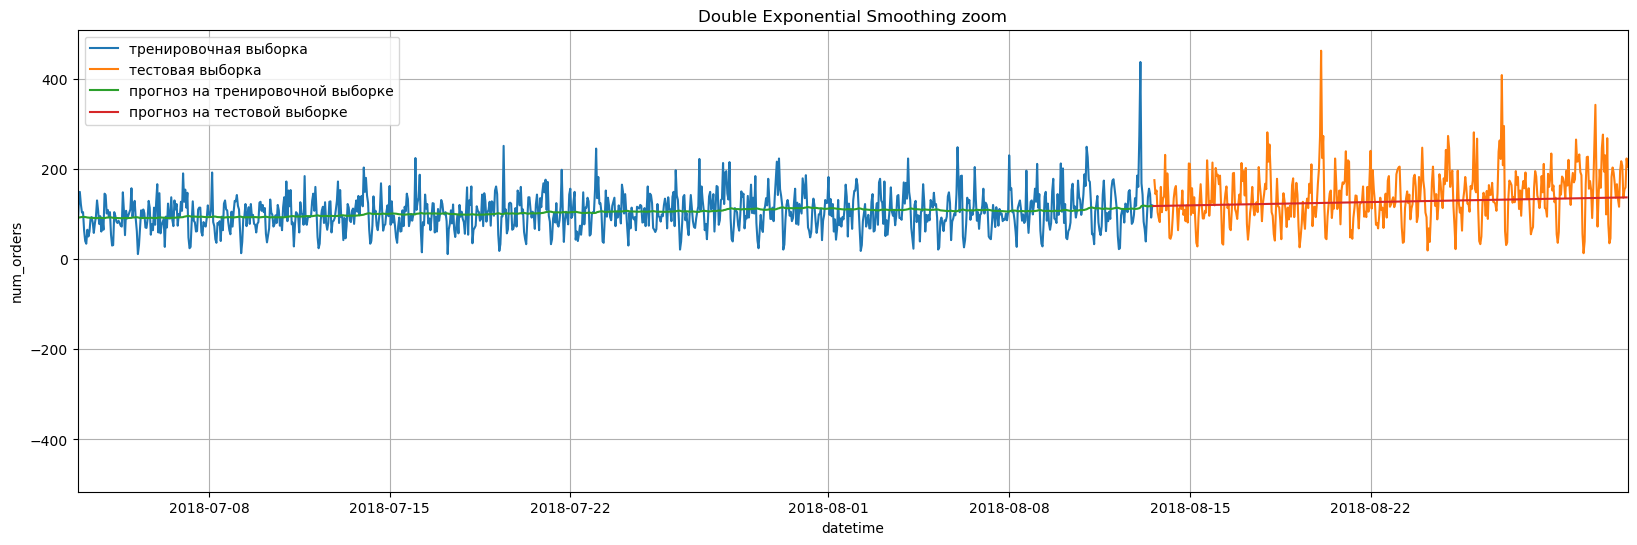

In [87]:
plot_forecast(train, test, predict_train, predict_test, 'Double Exponential Smoothing',zoom=True,xlim=[-1000,-1])

Как видно по графику - появился тренд, но прогноз по прежнему оставляет желать лучшего.

Рассмотрим прогноз тройного экспоненциального сглаживания (Holt-Winter's Model):

In [88]:
predict_train, predict_test = predict_ExpSm(train, test, params_tes)

RMSE на тренировочной выборке: 21.4
RMSE на тестовой выборке: 55.5


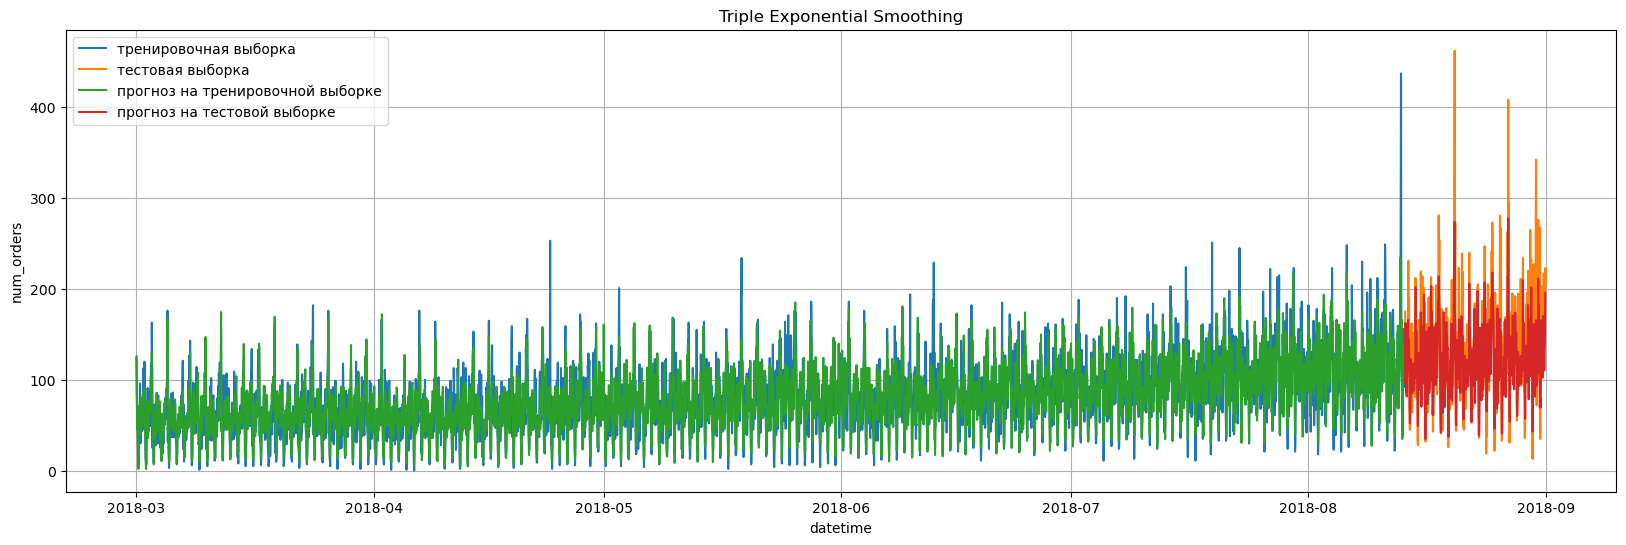

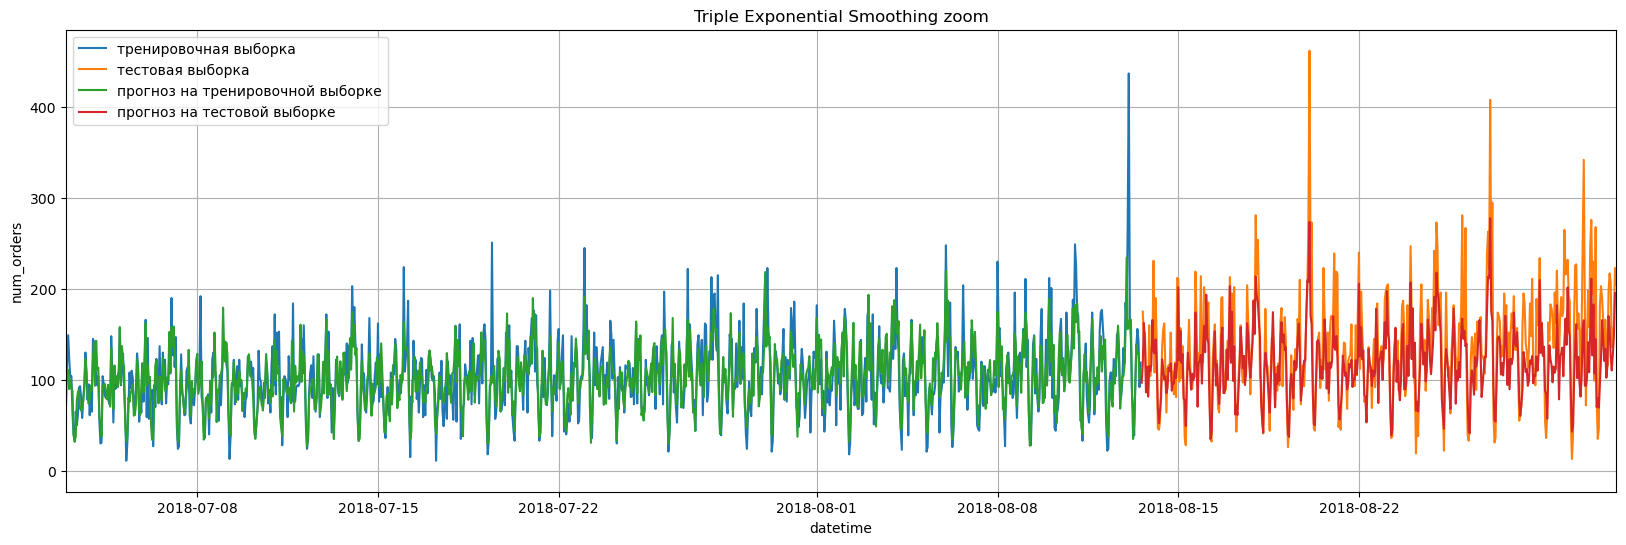

In [89]:
plot_forecast(train, test, predict_train, predict_test, 'Triple Exponential Smoothing',zoom=True,xlim=[-1000,-1])

К сожалению, учет сезонности также не позволил преодолеть максимальный порог метрики. Очевидно, что экспоненциальные модели очень чувствительны к гиперпараметрам и выборкам кроссвалидации, что существенно затрудняет их эффективное применение.

## 5.2. <a id='toc5_2_'></a>[<font color='#42AAFF'>SARIMAX</font>](#toc0_)

Рассмотрим прогноз наилучшей модели SARIMAX:

RMSE модели SARIMAX на тестовой выборке: 35.5


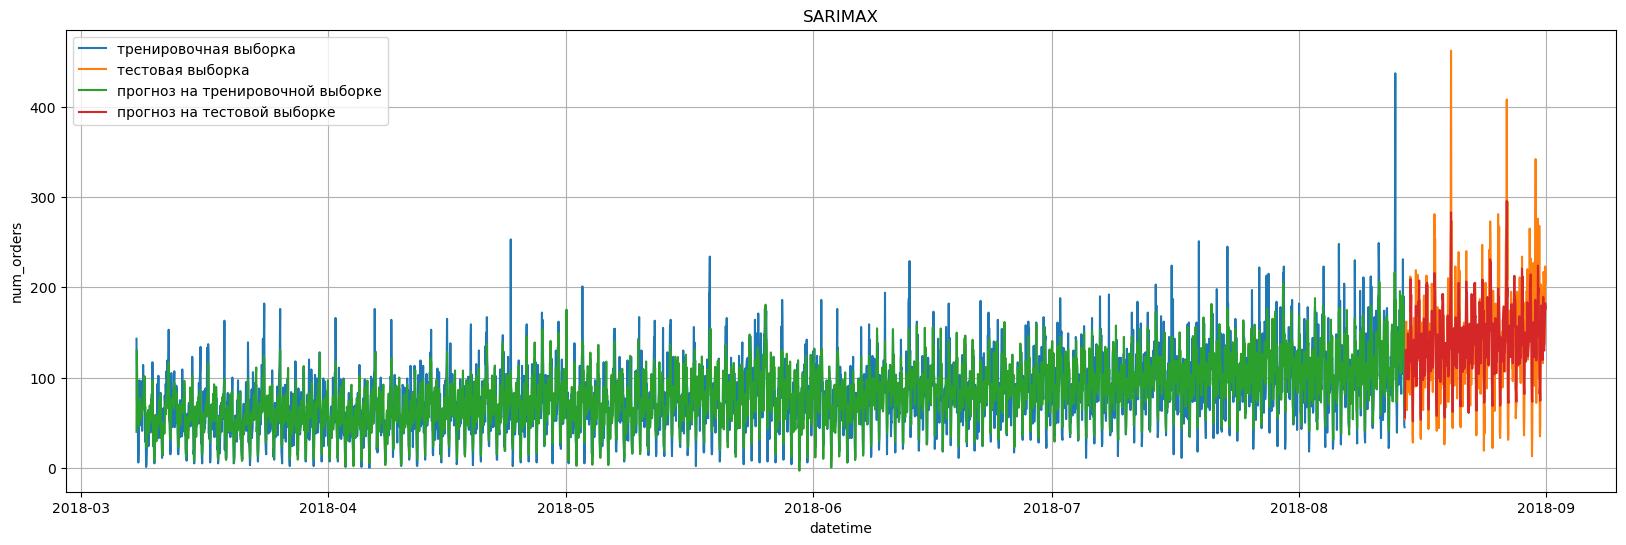

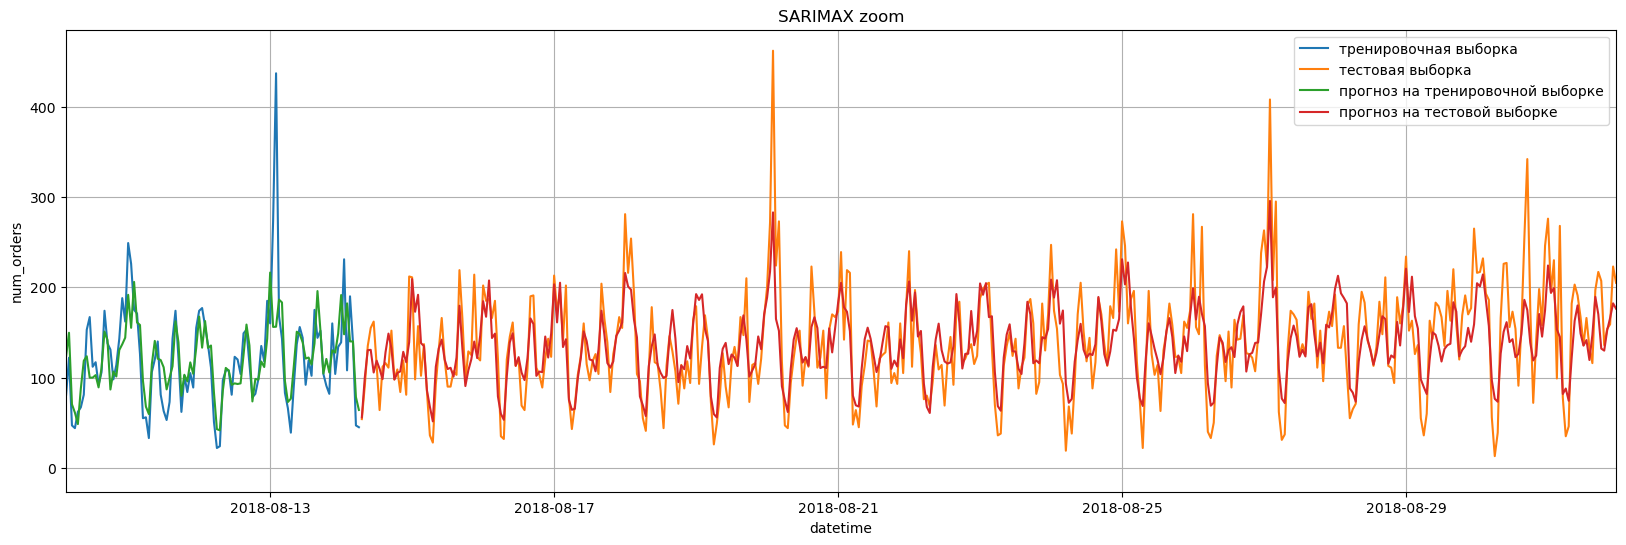

Wall time: 1min 4s


In [90]:
%%time
model = load('sarimax.joblib')
model = model.fit()

predict_train = pd.DataFrame(
    model.predict(
        start = y_train.index[0], 
        end = y_train.index[-1],
        exog = x_test_sarimax[['lag_168']]))

predict_test = pd.DataFrame(
    model.predict(
        start = y_test.index[0], 
        end = y_test.index[-1],
        exog = x_test_sarimax[['lag_168']]))
 
sarima_test_rmse = RMSE(y_test.values, predict_test.values)
print(f'RMSE модели SARIMAX на тестовой выборке: {sarima_test_rmse:3.1f}')
plot_forecast(y_train, y_test, predict_train, predict_test , 'SARIMAX', zoom=True, xlim=[-100,-1])

## 5.3. <a id='toc5_3_'></a>[<font color='#42AAFF'>Линейная регрессия</font>](#toc0_)

Линейная регрессия по 4 признакам позволила обеспечить RMSE 38.4, что существенно меньше, чем требуемые 48. 

RMSE на тренировочной выборке: 22.3
RMSE на тестовой выборке: 38.4


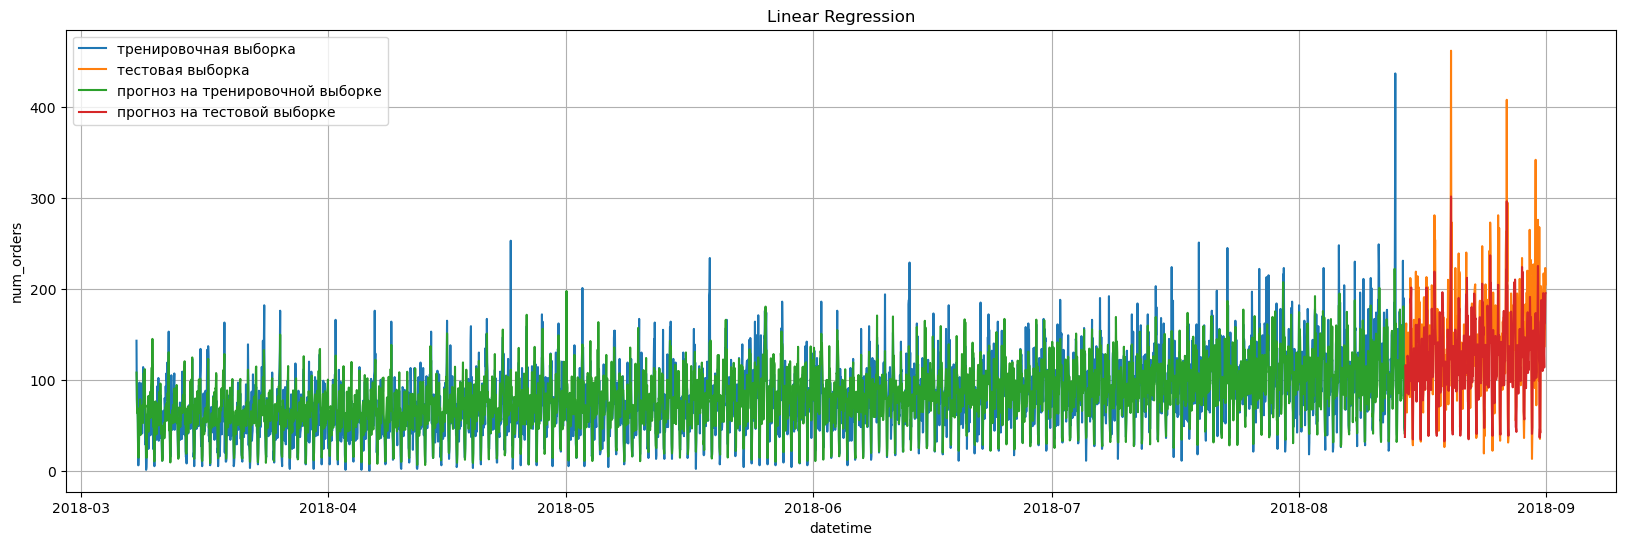

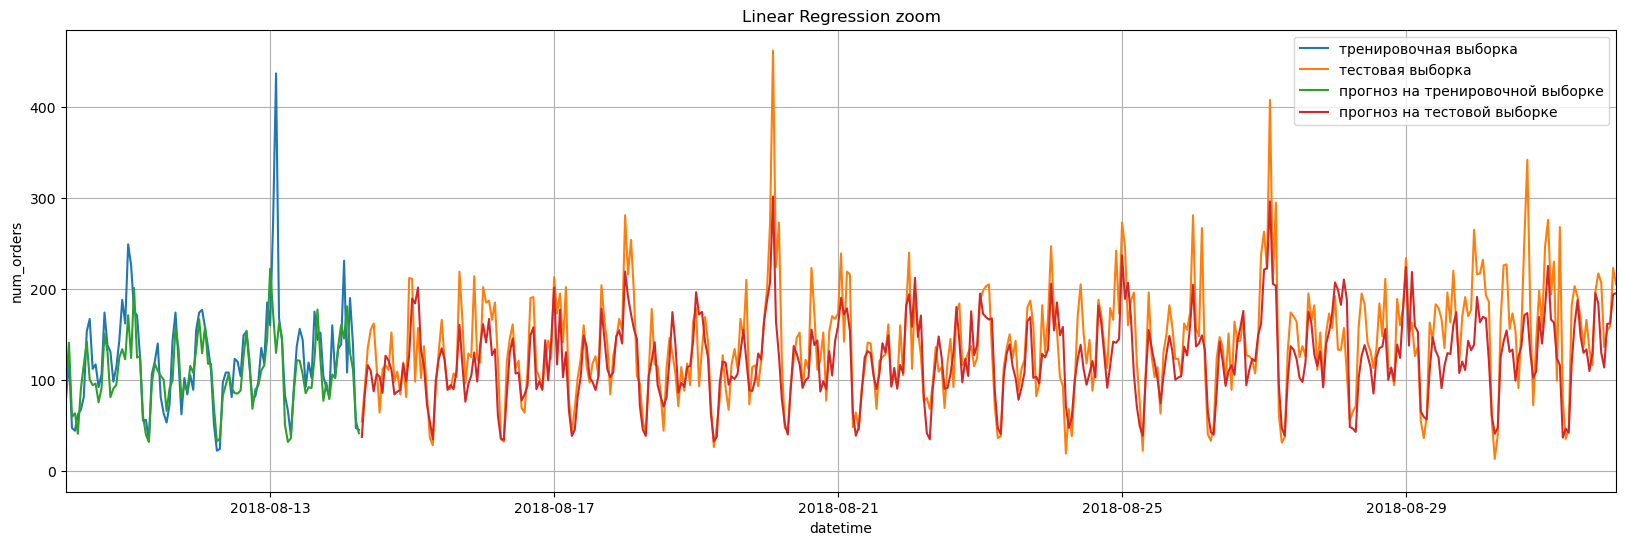

Wall time: 1.28 s


In [91]:
%%time
model = load('linreg_v01.joblib')
model.fit(x_train[coeff['feature']], y_train)
pred_train = pd.DataFrame(model.predict(x_train[coeff['feature']]),index=x_train.index)
pred_test = pd.DataFrame(model.predict(x_test[coeff['feature']]),index=x_test.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test, pred_test):0.1f}')
plot_forecast(y_train, y_test, pred_train, pred_test, 'Linear Regression',zoom=True,xlim=[-100,-1])

## 5.4. <a id='toc5_4_'></a>[<font color='#42AAFF'>CatBoost</font>](#toc0_)

RMSE на тренировочной выборке: 18.2
RMSE на тестовой выборке: 41.6


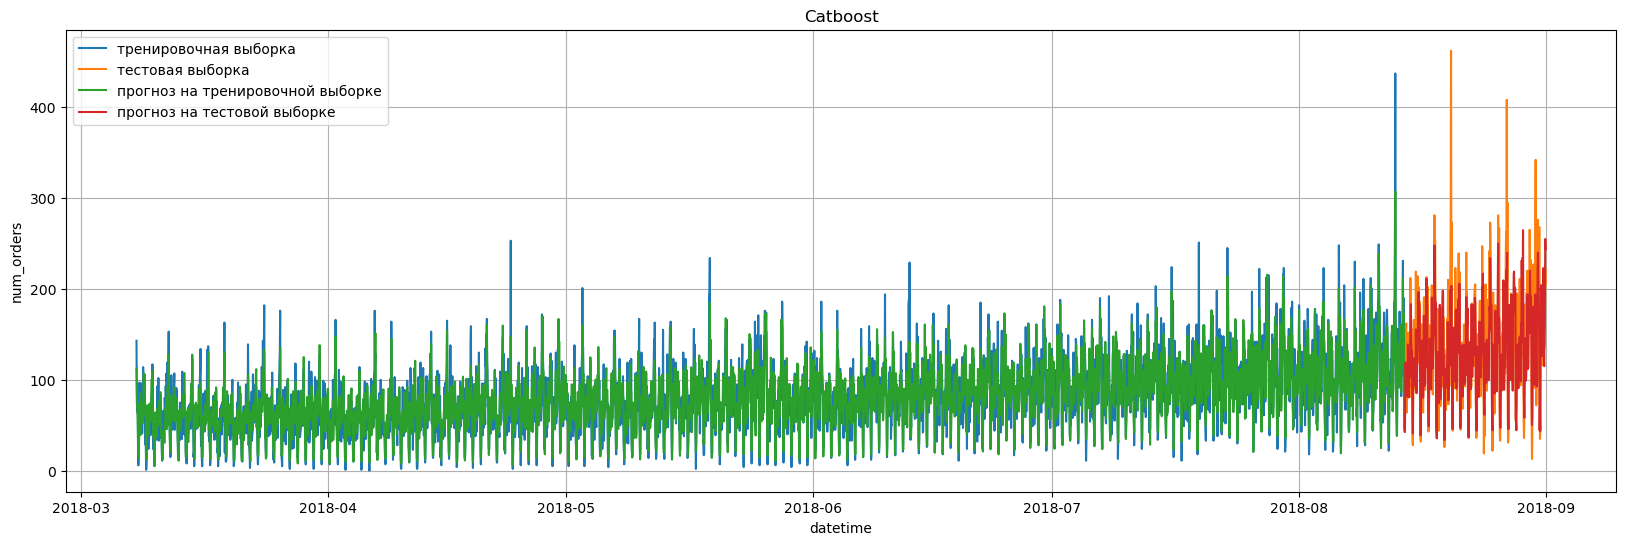

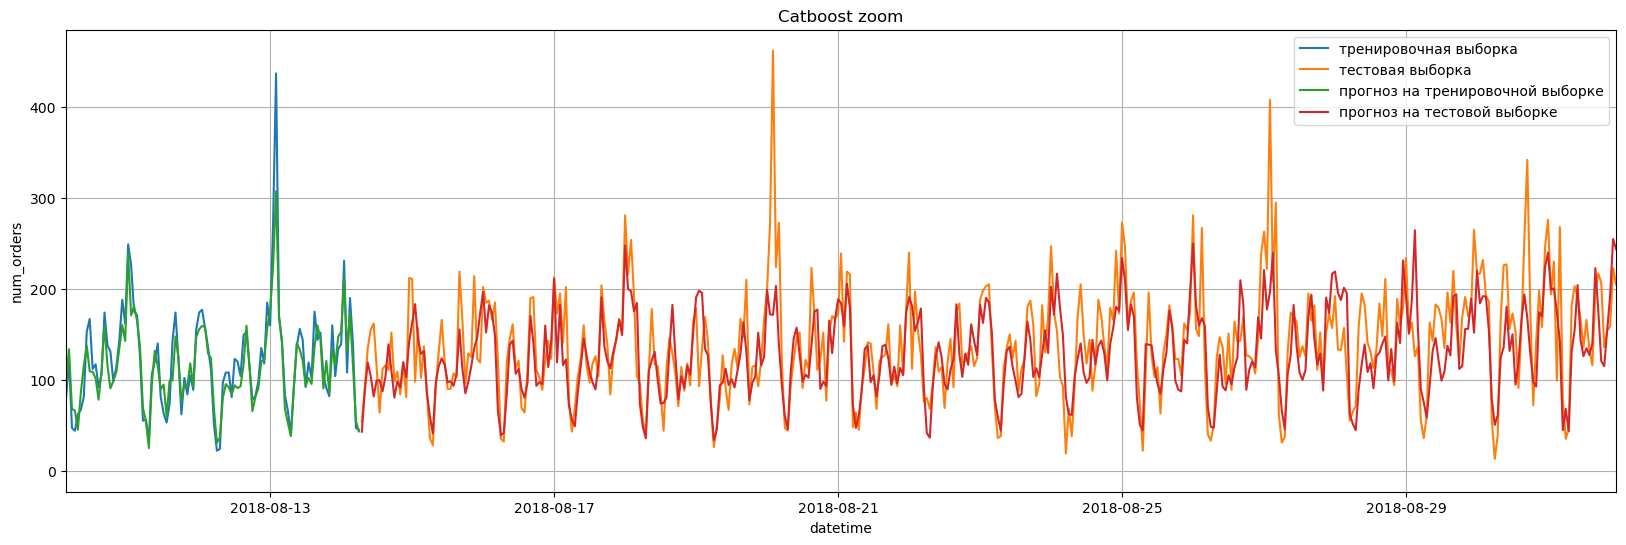

Wall time: 1.22 s


In [92]:
%%time
model = load('catboost.joblib')
model.fit(x_train.values, y_train,verbose=False)
pred_train = pd.DataFrame(model.predict(x_train.values),index=x_train.index)
pred_test = pd.DataFrame(model.predict(x_test.values),index=x_test.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test, pred_test):0.1f}')
plot_forecast(y_train, y_test, pred_train, pred_test, 'Catboost',zoom=True,xlim=[-100,-1])

Catboost также позволил уложиться в требования к точности, хотя показал и несколько худшие значения метрики.

## 5.5. <a id='toc5_5_'></a>[<font color='#42AAFF'>XGBoost</font>](#toc0_)

RMSE на тренировочной выборке: 19.0
RMSE на тестовой выборке: 42.0


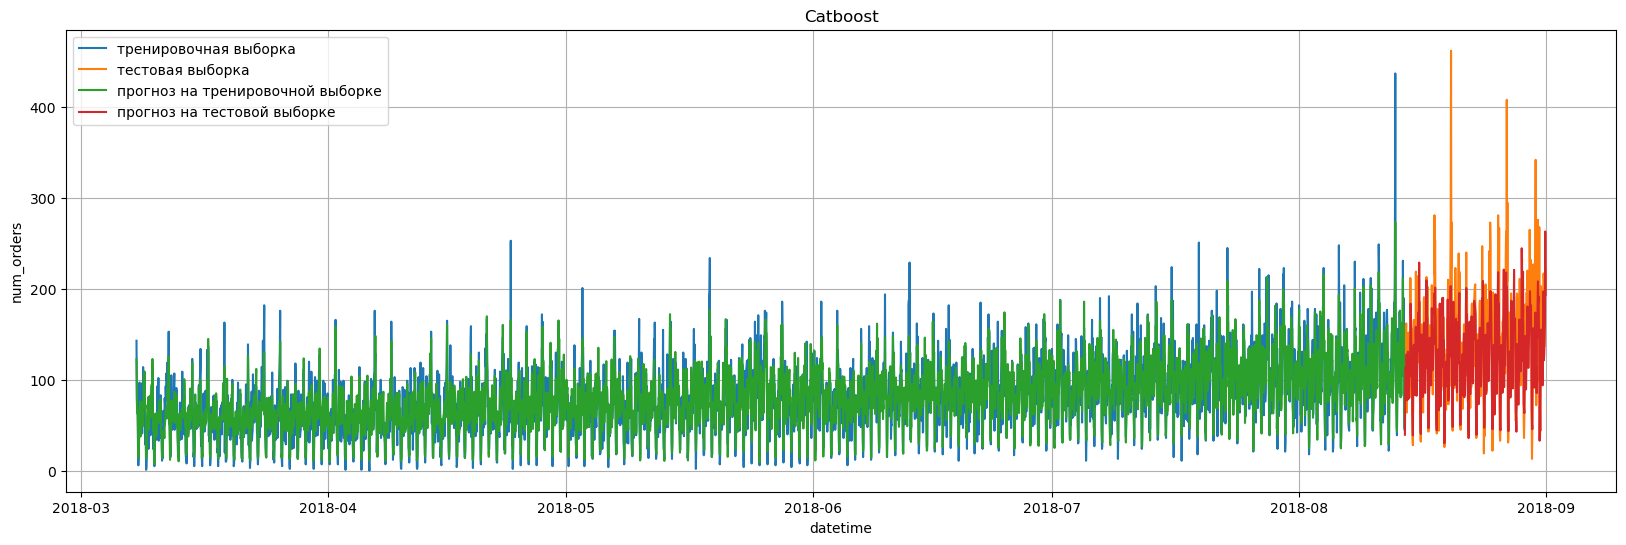

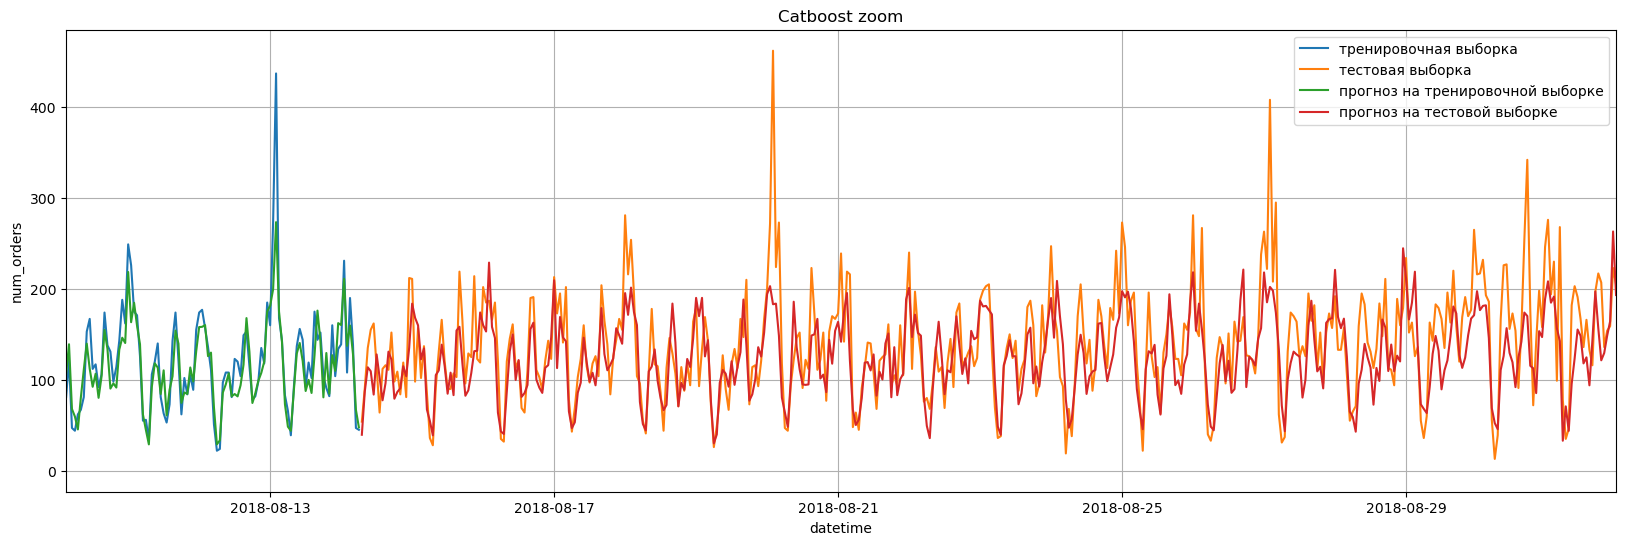

Wall time: 1.22 s


In [93]:
%%time
model = load('xgboost.joblib')
model.fit(x_train.values, y_train,verbose=False)
pred_train = pd.DataFrame(model.predict(x_train.values),index=x_train.index)
pred_test = pd.DataFrame(model.predict(x_test.values),index=x_test.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test, pred_test):0.1f}')
plot_forecast(y_train, y_test, pred_train, pred_test, 'Catboost',zoom=True,xlim=[-100,-1])

## 5.6. <a id='toc5_6_'></a>[<font color='#42AAFF'>LightGBM</font>](#toc0_)

RMSE на тренировочной выборке: 19.4
RMSE на тестовой выборке: 39.8


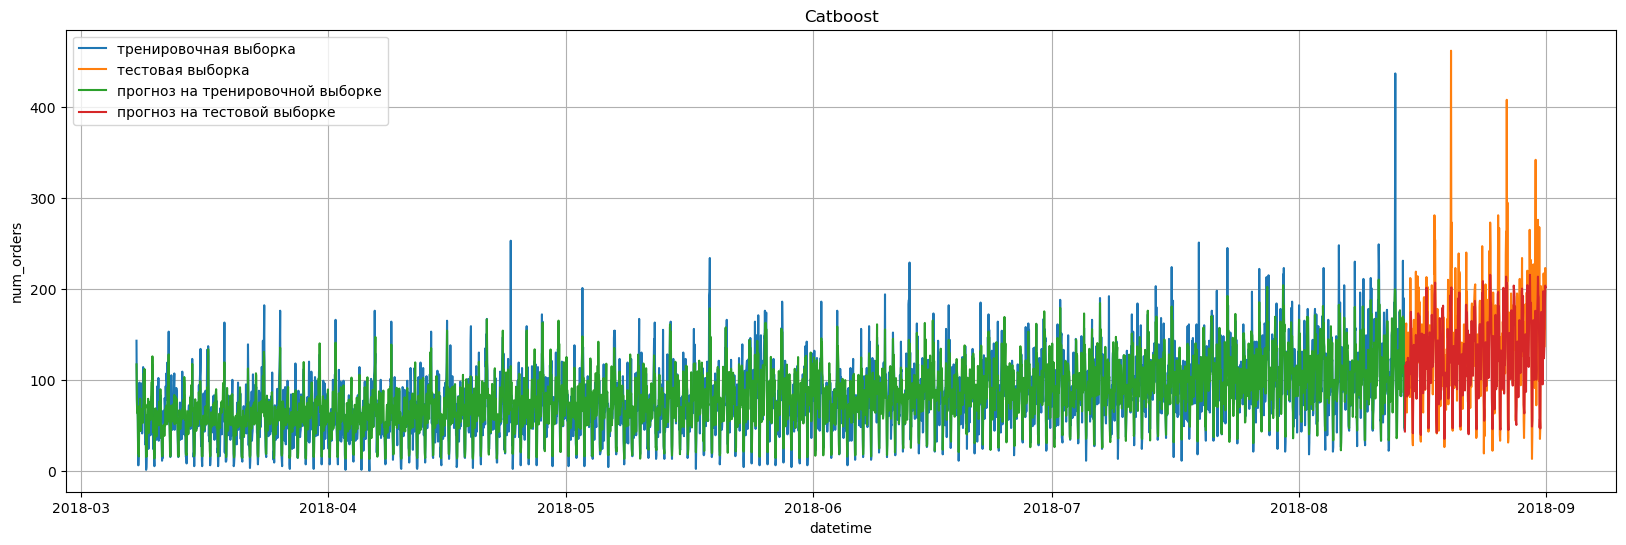

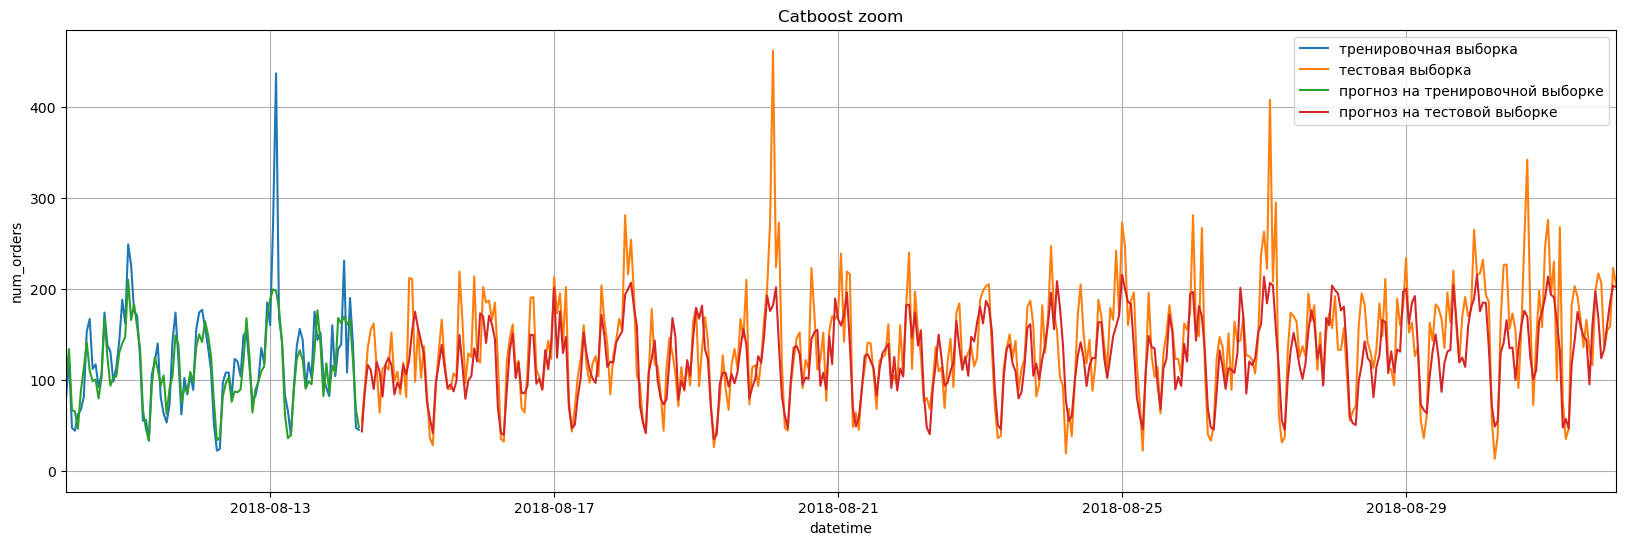

Wall time: 1.12 s


In [94]:
%%time
model = load('lgbm.joblib')
model.fit(x_train.values, y_train[y_train.columns[0]],verbose=False)
pred_train = pd.DataFrame(model.predict(x_train.values),index=x_train.index)
pred_test = pd.DataFrame(model.predict(x_test.values),index=x_test.index)
print(f'RMSE на тренировочной выборке: {RMSE(y_train, pred_train):0.1f}')
print(f'RMSE на тестовой выборке: {RMSE(y_test, pred_test):0.1f}')
plot_forecast(y_train, y_test, pred_train, pred_test, 'Catboost',zoom=True,xlim=[-100,-1])

In [96]:
index = ['SES','DES','TES','SARIMAX','LinearRegression','СatBoost','XGBoost','LGBM']
cols = ['RMSE']
data=[63.2, 59.0, 55.5, 35.5, 38.4, 41.6, 42.0, 39.8]
df_pivot = pd.DataFrame(index=index, columns=cols,data=data)  
print(df_pivot)

                  RMSE
SES               63.2
DES               59.0
TES               55.5
SARIMAX           35.5
LinearRegression  38.4
СatBoost          41.6
XGBoost           42.0
LGBM              39.8


# 6. <a id='toc6_'></a>[<font color='#42AAFF'>Общие выводы</font>](#toc0_)

I. Подготовка данных

1. Загрузили данные - 26495 строк и 2 столбца: `datetime` - время, `num_orders` - число заказов.
2. Преобразовали тип данных `datetime` в `datetime64` и выбрали столбец в качестве индекса.
3. Проверили, что пропусков в данных нет.
4. Убедились, что столбец времени монотонен.
5. Изменили частоту дискретизации данных до 1 часа.
6. Показали, что исходный ряд имеет тренд и сезонные компоненты.
7. Проверили стационарность ряда остатков с помощью расширенного теста Дики-Фуллера.

II. Обучение моделей

1. Подготовили вспомогательные функции:
    - блочного разбиения временного ряда для проведения кроссвалидации
    - визуализации кроссвалидационных выборок
    - визуализации прогнозов моделей
    - оптимизации параметров экспоненциальных моделей на кроссвалидации
    - прогноза для экспоненциальных моделей
    - подготовки данных для моделей линейной регрессии и бустингов
    - определения VIF для проверки мультиколлинеарности признаков
    - рекурсивного исключения мультиколлинеарных факторов
    - визуализации зависимости среднего значения метрики по кроссвалидационным выборкам от числа признаков    
2. Обучили экспоненциальные модели Simple Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing:
    - выбрали кроссвалидационные выборки
    - оптимизировали параметры каждой из моделей на кроссвалидационных выборках
    - визуализировали прогноз на тренировочной и тестовой кроссвалидационной выборке
    - получили значения RMSE, только Triple Exponential Smoothing имеет некоторые шансы уложиться в требования по RMSE=48 на тестовой выборке
3. Обучили модель SARIMAX:
    - подготовили лаги для использования в качестве X факторов 
    - выбрали кроссвалидационные выборки    
    - оптимизировали параметры каждой из моделей на кроссвалидационных выборках
    - визуализировали прогноз на тренировочной и тестовой кроссвалидационной выборке
    - получили среднее значение на тестовых выборках RMSE = 27.5 
4. Обучили модель линейной регрессии:
    - выбрали кроссвалидационные выборки
    - убедились, что выбранные признаки неколлинеарны
    - на кроссвалидационных выборках оптимизировали количество признаков: сильнее всего на метрику влияет недельный лаг, также имеют существенное влияние 1 и 2х суточные лаги и почасовое усреднение
    - среднее RMSE на тестовых выборках примерно равно 35, но наблюдался существенный разброс метрики.
5. Обучили бустинговые модели: CatBoost, XGBoost, LightGBM:
    - оптимизировали гиперпараметры моделей на кроссвалидации
    - оптимизированные модели показали удовлетворительные прогнозы на тестовых выборках с RMSE ~ 35
    - любопытно, что важность признаков бустинговые модели оценивают по-разному - выделяют те же 4 наиболее сильно влияющие признаки, что и линейная регрессия, но количественно по-разному оценивают степень их важности.

III. Тестирование моделей.

1. Оптимизированные экспоненциалные модели не позволили предсказать с требуемой точностью, наилучший результат у модели Хольта-Винтерса - 55.5.
2. SARIMAX модель позволила получить RMSE ~ 35.5, но время оптимизации модели очень велико и потребовало некоторых априорных предположений об X факторах.
3. Линейная регрессия показала наилучший среди всех моделей результат - 38.4.
3. CatBoost, XGBoost, LightGBM показали близкие результаты - ~40-42.